# Risques et performances - PROJET 2020
### *Morgane MONESTIER, Marie-Lidwine TARDIF, Lucille DEPLANTE*

Fonds choisi : FR0010591362

Remarque : veillez à bien télécharger nos fichiers de prix/compositions 

### Importation des librairies

In [1]:
import pandas as pd 
from datetime import datetime
import numpy as np 
import matplotlib.pyplot as plt #manipulation de graphique
from matplotlib.ticker import PercentFormatter
from matplotlib import cm
%matplotlib inline
from pandas.plotting import register_matplotlib_converters #Essentiel pour jupyter notebook
from scipy.stats import norm, t, jarque_bera, skew, kurtosis, binom_test # importation des fonctions stat utilisées
from sklearn import linear_model
import scipy.optimize as spo # pour l'optimisation

## Etape préliminaire - Importation et traitement des données

#### Chargement des données de marché (fichier prices.csv) :

In [2]:
data=pd.read_csv("Prices.csv", sep=";", decimal=".", encoding='latin') #Chargement du fichier des prix
pd.to_datetime(data['date']) 
data['Security']=data['Label'].map(str)+"-"+data['Isin'].map(str)# Ajout d'une colonne "security" contenant l'isin et le label

#### Matrice des prix 

In [3]:
Prices=data[['date','Security','Price']].pivot_table(index='date',columns='Security', values = 'Price').dropna() #on a bien les 70 actifs 
Prices.rename(columns={'CAC 40-FR0003500008':'CAC40'},inplace=True)
Prices.rename(columns={'CAC40Shortx1-CAC40Shortx1':'CAC40Shortx1'},inplace=True)
Prices.sort_values(by="date",ascending = True).head(4)

Security,ACCOR SA-FR0000120404,ADP-FR0010340141,AIR LIQUIDE SA-FR0000120073,ALTEN-FR0000071946,AXA SA-FR0000120628,Airbus SE-NL0000235190,ArcelorMittal-LU1598757687,AtoS-FR0000051732,BNP PARIBAS-FR0000131104,BOUYGUES SA-FR0000120503,...,Societes Financieres-QS0011017801,THALES SA-FR0000121329,TOTAL SA-FR0000120271,TechnipFMC PLC-GB00BDSFG982,Technologie-QS0011017827,Telecommunications-QS0011017769,UNIBAIL RODAMCO SE-FR0013326246,VEOLIA ENVIRONNEMENT-FR0000124141,Vinci SA-FR0000125486,Vivendi SA-FR0000127771
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,33.753811,89.920151,78.652870,32.272186,14.846847,37.826546,17.898468,44.635635,38.832279,23.902941,...,740.19,41.032413,32.523880,39.371868,808.73,679.54,162.700775,11.974454,39.190189,15.938168
2015-01-05,33.319206,88.296593,76.217232,32.267548,14.294949,37.940418,17.211905,44.001377,36.946838,23.019270,...,717.47,40.581348,30.577419,37.831532,800.43,653.42,161.393326,11.676825,37.857262,15.612500
2015-01-06,32.622040,88.127106,75.581253,31.238617,14.139485,38.819473,17.208008,42.835255,35.980549,22.844126,...,709.06,40.699818,30.531525,37.044426,784.03,646.19,161.624039,11.513741,37.443138,15.352744
2015-01-07,32.785019,89.697136,75.922554,31.688200,14.291062,39.830601,17.180155,42.657909,35.379562,23.110819,...,707.96,41.187321,31.223698,35.783382,782.06,656.81,163.931320,11.603436,38.823536,15.383761


#### Cours en base 100 :

In [4]:
Prices_Rebased=Prices/Prices.iloc[0]*100 #cours base 100
Prices_Rebased.head(4)

Security,ACCOR SA-FR0000120404,ADP-FR0010340141,AIR LIQUIDE SA-FR0000120073,ALTEN-FR0000071946,AXA SA-FR0000120628,Airbus SE-NL0000235190,ArcelorMittal-LU1598757687,AtoS-FR0000051732,BNP PARIBAS-FR0000131104,BOUYGUES SA-FR0000120503,...,Societes Financieres-QS0011017801,THALES SA-FR0000121329,TOTAL SA-FR0000120271,TechnipFMC PLC-GB00BDSFG982,Technologie-QS0011017827,Telecommunications-QS0011017769,UNIBAIL RODAMCO SE-FR0013326246,VEOLIA ENVIRONNEMENT-FR0000124141,Vinci SA-FR0000125486,Vivendi SA-FR0000127771
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2015-01-05,98.712428,98.194445,96.903307,99.985626,96.282726,100.301037,96.164121,98.579032,95.144655,96.303087,...,96.930518,98.900710,94.015287,96.087723,98.973700,96.156223,99.196409,97.514464,96.598825,97.956679
2015-01-06,96.646983,98.005959,96.094717,96.797337,95.235608,102.624948,96.142350,95.966495,92.656290,95.570357,...,95.794323,99.189431,93.874178,94.088566,96.945829,95.092268,99.338211,96.152531,95.542122,96.326905
2015-01-07,97.129829,99.751986,96.528651,98.190435,96.256545,105.298012,95.986734,95.569177,91.108642,96.686090,...,95.645713,100.377524,96.002377,90.885661,96.702237,96.655090,100.756324,96.901592,99.064427,96.521514


####  Matrice des rendements logarithmiques 

In [5]:
Returns=np.log(Prices.pct_change(1).fillna(0)+1)
Returns.head(4)

Security,ACCOR SA-FR0000120404,ADP-FR0010340141,AIR LIQUIDE SA-FR0000120073,ALTEN-FR0000071946,AXA SA-FR0000120628,Airbus SE-NL0000235190,ArcelorMittal-LU1598757687,AtoS-FR0000051732,BNP PARIBAS-FR0000131104,BOUYGUES SA-FR0000120503,...,Societes Financieres-QS0011017801,THALES SA-FR0000121329,TOTAL SA-FR0000120271,TechnipFMC PLC-GB00BDSFG982,Technologie-QS0011017827,Telecommunications-QS0011017769,UNIBAIL RODAMCO SE-FR0013326246,VEOLIA ENVIRONNEMENT-FR0000124141,Vinci SA-FR0000125486,Vivendi SA-FR0000127771
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-05,-0.012959,-0.018221,-0.031457,-0.000144,-0.037881,0.003006,-0.039114,-0.014312,-0.049772,-0.037670,...,-0.031176,-0.011054,-0.061713,-0.039909,-0.010316,-0.039196,-0.008068,-0.025169,-0.034604,-0.020645
2015-01-06,-0.021146,-0.001921,-0.008379,-0.032407,-0.010935,0.022905,-0.000226,-0.026859,-0.026502,-0.007638,...,-0.011791,0.002915,-0.001502,-0.021025,-0.020702,-0.011127,0.001428,-0.014065,-0.010999,-0.016778
2015-01-07,0.004984,0.017659,0.004506,0.014289,0.010663,0.025713,-0.001620,-0.004149,-0.016844,0.011607,...,-0.001553,0.011907,0.022418,-0.034634,-0.002516,0.016301,0.014175,0.007760,0.036203,0.002018


#### Compositions du fonds étudié et de son benchmark (CAC40)

In [6]:
compo=pd.read_csv("Compositions.csv", sep=";",decimal=".") # Chargement du fichier des compo
compo['Security']=compo['Name'].map(str)+"-"+compo['ISIN'].map(str) #création d'un nom de security composé de l'isin et du label
compo.head(4)

,Indice,ISIN,Name,Weight,Sector,Country,Currency,Type,Security
0,CAC40,CAC40TN,CAC40TN,0.0,Index,FRANCE,EUR,Bench,CAC40TN-CAC40TN
1,CAC40,CACTN,CAC All Tradable TR,0.0,Index,FRANCE,EUR,Bench,CAC All Tradable TR-CACTN
2,CAC40,CAC40Shortx1,CAC40Shortx1,0.0,Index,FRANCE,EUR,Bench,CAC40Shortx1-CAC40Shortx1
3,CAC40,CAC40Shortx2,CAC40Shortx2,0.0,Index,FRANCE,EUR,Bench,CAC40Shortx2-CAC40Shortx2


Nous émettons l'hypothèse que le fonds n'est pas rebalancé (il nous faudra calculer la nav et vl du fonds à chaque date)

## Etape 1 - Analyse du fonds intial

Remarque : l'ensemble des variables se rapportant au fonds initial sont notées "Pf", celle se rapportant à l'ETF FR0010591362 sont appelées "ETF" et le CAC40 est désigné par "CAC". 

### Composition du fonds et du bench

Le choix de l'indice CAC 40 nous donne déjà une indication sur la stratégie de gestion de ce fonds, que nous confirme la composition affichée ci-dessous : ce fonds action investit dans les plus grosses sociétés cotées françaises.

#### Poids de chaque actifs dans le fonds et le benchmark : 

In [7]:
Compo_Pf_CAC =compo[(compo['Indice']=='Fonds')|(compo['Indice']=='CAC40')|(compo['Indice']=='ETF')].copy()
Compo_Pf_CAC=pd.pivot_table(Compo_Pf_CAC, index="Security", columns="Indice",values="Weight")
Compo_Pf_CAC.sort_index(inplace=True)
Compo_Pf_CAC.columns.name = "Poids des actifs"
Compo_Pf_CAC.head(4)

Poids des actifs,CAC40,ETF,Fonds
Security,,,
ACCOR SA-FR0000120404,0.005297,NaN,0.000000
ADP-FR0010340141,0.000000,NaN,0.061028
AIR LIQUIDE SA-FR0000120073,0.047876,NaN,0.000000
ALTEN-FR0000071946,0.000000,NaN,0.021413


#### Analyse des pondérations sectorielles

In [8]:
#Récupération des secteurs associés à chaque actif
Compo_Pf_CAC_sect = compo.join(Compo_Pf_CAC,on="Security",how="right")
Compo_Pf_CAC_sect.drop({"Indice","ISIN","Name","Weight","Currency","Country","Type"},axis=1,inplace=True)
Compo_Pf_CAC_sect.set_index("Security",inplace=True)
Compo_Pf_CAC_sect.sort_index(inplace=True)
Compo_Pf_CAC_sect.drop_duplicates(inplace=True)
Compo_Pf_CAC_sect = Compo_Pf_CAC_sect[(Compo_Pf_CAC_sect[['CAC40','Fonds']]==0).all(1)==False] #supprime positions à 0

In [9]:
#Calcul des surpondérations 
Compo_Pf_CAC_sect["Fonds-CAC"]=Compo_Pf_CAC_sect["Fonds"]-Compo_Pf_CAC_sect["CAC40"]
Ponder_sector = Compo_Pf_CAC_sect.groupby("Sector").sum()
Ponder_sector.sort_values(by='Fonds-CAC',inplace=True)
Ponder_sector

,CAC40,ETF,Fonds,Fonds-CAC
Sector,,,,
Financials,0.109845,0.0,0.000000,-0.109845
Materials,0.055872,0.0,0.000000,-0.055872
Consumer Staples,0.115442,0.0,0.063862,-0.051580
Health Care,0.076562,0.0,0.029097,-0.047465
Utilities,0.032684,0.0,0.000000,-0.032684
Energy,0.089455,0.0,0.059201,-0.030254
Industrials,0.213093,0.0,0.235987,0.022893
Consumer Discretionary,0.206897,0.0,0.236532,0.029636
Information Technology,0.047576,0.0,0.090943,0.043367


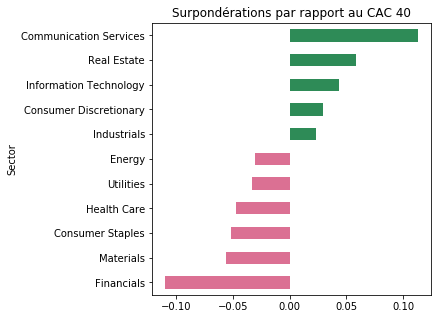

In [10]:
Ponder_sector['positive'] = Ponder_sector['Fonds-CAC']>0
plt.figure(figsize=(5,5))
Ponder_sector['Fonds-CAC'].plot(kind='barh',color=Ponder_sector.positive.map({True: 'seagreen', False: 'palevioletred'}),title="Surpondérations par rapport au CAC 40")

On s'aperçoit que le gérant est sous-exposé notamment sur les secteurs des financières, des matériaux, des biens de consommations et de la santé. Ses convictions sur les financières sont très mauvaises. Il est en revanche sur-exposé sur les services de communications et d'immobilier, mais aussi en technologies de l'information.

### Analyse de la performance 

In [11]:
def Fonds(CompoFonds, Rendts, Output, StartDate = "2015-01-02", Bench=None, Short=False):
    # fonction permettant de calculer la série de rendement OU les prix en base 100 OU les prix d'une série 
    # CompoFonds : composition du fonds 
    # Rendts : rendements des différents titres 
    # Output : type d'output souhaité ("Rendements" pour une série de rendements 
    #   et "Prix" pour une série de prix base 100)
    # StartDate (optionel) : date de départ (défaut au 2015-01-02)
    # Bench (optionel) : benchmark à analyser (défaut à "")
    # Short (optionel) : fonds short par rapport à son benchmark (défaul à "false")
    if Output == "Rendements":
        Fund=CompoFonds.loc[StartDate:].T*Rendts.loc[StartDate:,:]
        Fund=Fund.sum(axis=1)
        Title="Rendements"
        if Bench != None:
            Benchmark=Rendts.loc[StartDate:,Bench]
    elif Output == "Prix":
        Fund=CompoFonds.loc[StartDate:].T*Prices.loc[StartDate:,:]
        Fund=Fund.sum(axis=1)
        Title="Prix"
        if Bench != None:
            Benchmark=Prices.loc[StartDate:,Bench]
    elif Output == "PrixBase100":
        Fund=CompoFonds.loc[StartDate:].T*Prices.loc[StartDate:,:]
        Fund=Fund.sum(axis=1)
        Fund=Fund/Fund.iloc[0]*100
        Title="Prix base 100"
        if Bench != None:
            Benchmark=Prices.loc[StartDate:,Bench]/Prices.loc[StartDate,Bench]*100
    Fund=pd.DataFrame(Fund,columns={"Fonds"})
    if Bench != None:
        Fund=Fund.join(Benchmark)
        Fund.columns.name=Title
        if Output == "Rendements":
            if Short:
                Fund["Relatif"]=-Fund["Fonds"]-Fund[Bench]
            else:
                Fund["Relatif"]=Fund["Fonds"]-Fund[Bench]
            Fund["Cuml"]=np.cumprod(1+Fund["Relatif"])*100
    return Fund

#### Prix du portefeuille et du benchmark

In [12]:
Prices_Pf_CAC = Fonds(Compo_Pf_CAC['Fonds'], Returns, "PrixBase100", Bench='CAC40')
Prices_Pf_CAC.head(4)

Prix base 100,Fonds,CAC40
date,,
2015-01-02,100.000000,100.000000
2015-01-05,98.646181,96.685786
2015-01-06,97.627364,96.030609
2015-01-07,97.639394,96.718004


#### Performance du fonds

La performance totale du fonds est :  61.47 %
La performance totale du benchmark est :  42.73 %


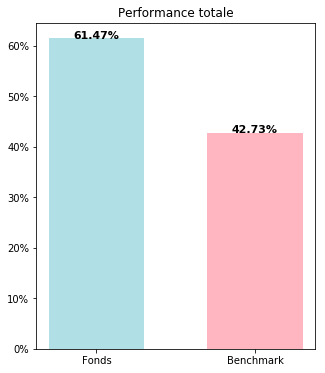

In [13]:
def PerfTot(Prix):
    # fonction permettant de calculer la performance totale 
    # Prix : prix de la série à analyser
    return Prix[-1]/Prix[0]-1

def FondsPlot(Fonds1, labelFonds1 ,Fonds2 = None, labelFonds2 = None, Fonds3 = None, labelFonds3 = None, Titre="Performance totale"):
    # fonction permettant de plot la perf ou vol de différents fonds afin de les comparer
    # Fonds1 : fonds 1
    # Fonds2 (optionel) : fonds 2
    # Fonds3 (optionel) : fonds 3
    # labelFonds1 : nom du fonds 1
    # labelFonds2 (optionel) : nom du fonds 2
    # labelFonds3 (optionel) : nom du fonds 3
    # Titre (optionel) : titre du graphique (défaut en "Performance totale")
    if Fonds1 == None:
        if Fonds3 == None:
            y = [Fonds1]
            label = [labelFonds1]
            bar = [1]
        else:
            y = [Fonds1,Fonds3]
            label = [labelFonds1,labelFonds3]
            bar = [1,2]
    else:
        if Fonds3 == None:
            y = [Fonds1,Fonds2]
            label = [labelFonds1,labelFonds2]
            bar = [1,2]
        else:
            y = [Fonds1,Fonds2,Fonds3]
            label = [labelFonds1,labelFonds2,labelFonds3]
            bar = [1,2,3]
    fig, axes = plt.subplots(figsize=(5,6))
    axes.bar(bar, y, width = 0.6, tick_label = label, color = ('powderblue','lightpink','lightgreen'))
    axes.yaxis.set_major_formatter(PercentFormatter())
    for i, v in enumerate(y):
        axes.text(i+1,v+0.002,'%.2f' % y[i]+"%",fontweight='bold',fontsize=11,ha='center')
    plt.title(Titre)
    plt.show()

perfTotalePf = PerfTot(Prices_Pf_CAC["Fonds"])
print("La performance totale du fonds est : ", (perfTotalePf *100).round(2), "%")
perfTotaleBench = PerfTot(Prices_Pf_CAC["CAC40"])
print("La performance totale du benchmark est : ", (perfTotaleBench *100).round(2), "%")
FondsPlot(perfTotalePf*100,"Fonds",Fonds2 = perfTotaleBench*100,labelFonds2 = "Benchmark")

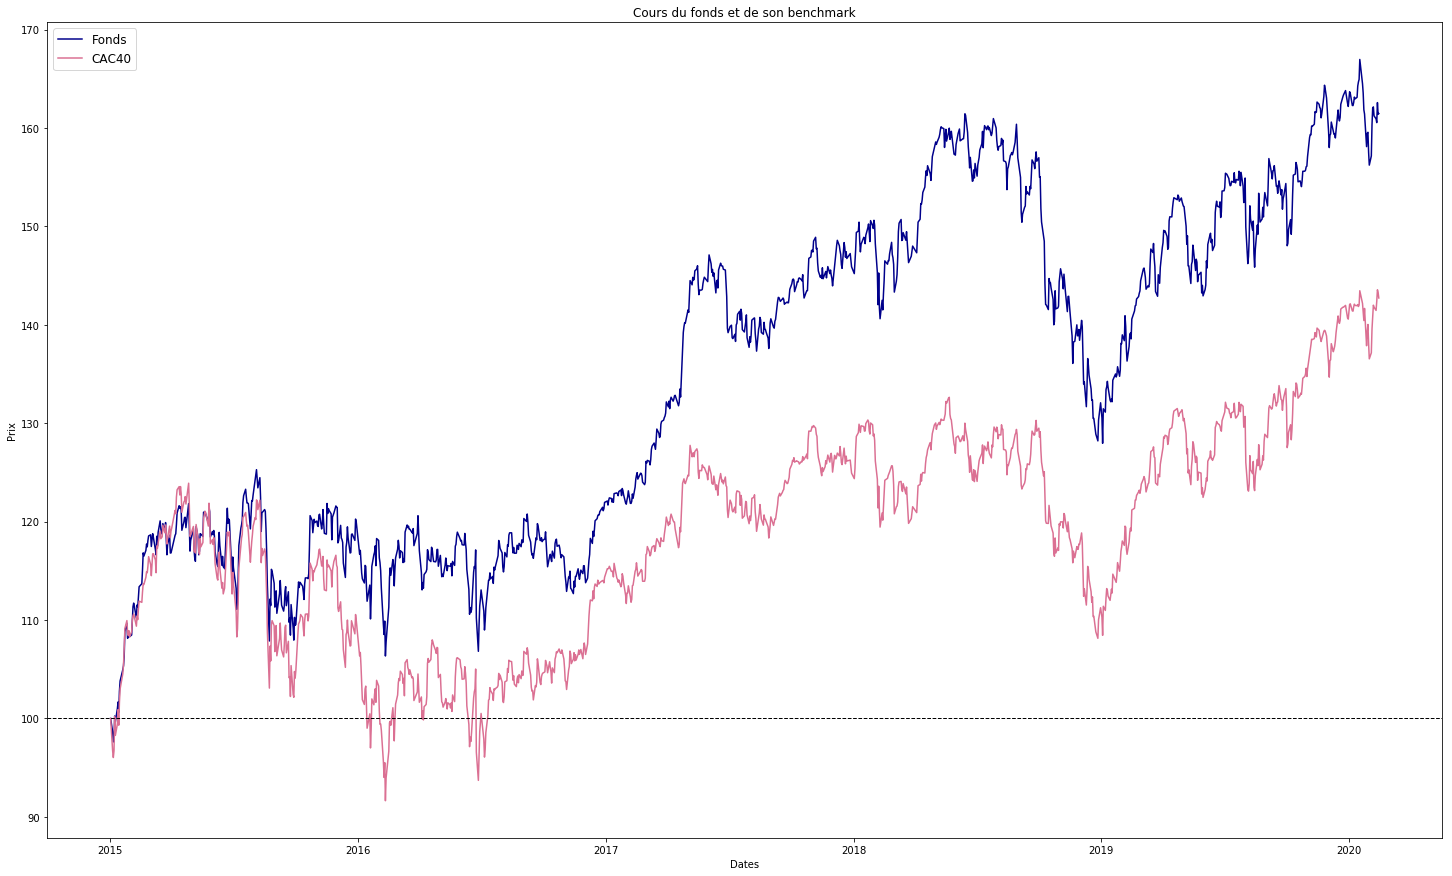

In [14]:
def PlotPerf(Dates, PrixFonds, PrixBench, LabelFonds, LabelBench):
    # fonction permettant de plot la performance du fonds et de son benchmark
    # Dates : dates
    # PrixFonds : prix du fonds à analyser 
    # PrixBench : prix du benchmark auquel comparer les cours 
    # LabelFonds : nom du fonds 
    # LabelBench : nom du benchmark 
    plt.figure(figsize=(25,15))
    plt.plot(pd.to_datetime(Dates), PrixFonds, color="darkblue", label=LabelFonds)
    plt.plot(pd.to_datetime(Dates), PrixBench, color="palevioletred", label=LabelBench)
    plt.axhline(y=100, color = "black", ls ="--", lw = 1)
    plt.xlabel("Dates")
    plt.ylabel("Prix")
    plt.title("Cours du fonds et de son benchmark")
    plt.legend(loc='best',fontsize=12)
    plt.show

PlotPerf(Prices_Pf_CAC.index, Prices_Pf_CAC['Fonds'], Prices_Pf_CAC['CAC40'],'Fonds','CAC40')

Sur l'ensemble de la période, la performance du fonds est toujours supérieure ou égale à celle du benchmark.

#### Rendements du portefeuille et de l'indice :  

In [15]:
Returns_Pf_CAC = Fonds(Compo_Pf_CAC['Fonds'], Returns, "Rendements", Bench='CAC40')
Returns_Pf_CAC.head(4)

Rendements,Fonds,CAC40,Relatif,Cuml
date,,,,
2015-01-02,0.000000,0.000000,0.000000,100.000000
2015-01-05,-0.019262,-0.033704,0.014441,101.444146
2015-01-06,-0.011578,-0.006799,-0.004779,100.959359
2015-01-07,0.006529,0.007133,-0.000603,100.898464


#### TE et excès de performance

Tracking error annualisée :  5.87 %


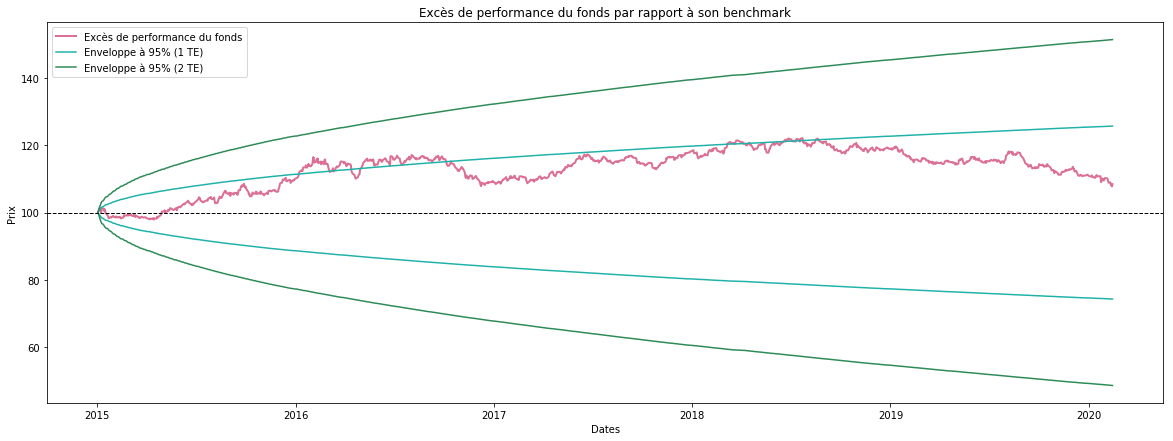

In [16]:
def TEexcPerf(Rendts, Freq=252, Graph=True):
    # fonction permettant de plot l'excès de performance du fonds par rapport à son benchmark et renvoie le TE 
    # Rendts : tableau de rendements (obtenu par la fonction Fonds)
    # Freq (optionel) : fréquence utilisée pour le calcul du TE (défaut : 252)
    # Graph (optionel) : permet à l'utilisateur d'afficher ou non le graphique (défaut à "true")
    TE=np.std(Rendts["Relatif"])*np.sqrt(Freq)
    if Graph:
        n=1-(1-0.95)/2
        T=np.arange(len(Rendts))
        Rendts["Env sup 95% (1 TE)"]=100 * (1+norm.ppf(n)*TE*np.sqrt(T/Freq)) #borne haute (1 TE)
        Rendts["Env inf 95% (1 TE)"]=100 * (1-norm.ppf(n)*TE*np.sqrt(T/Freq)) #borne basse (1 TE)
        Rendts["Env sup 95% (2 TE)"]=100 * (1+norm.ppf(n)*2*TE*np.sqrt(T/Freq)) #borne haute (2 TE)
        Rendts["Env inf 95% (2 TE)"]=100 * (1-norm.ppf(n)*2*TE*np.sqrt(T/Freq)) #borne basse (2 TE)
        plt.figure(figsize=(20,7))
        plt.plot(pd.to_datetime(Rendts.index), Rendts["Cuml"], color="palevioletred", label = "Excès de performance du fonds", lw = 2)
        plt.plot(pd.to_datetime(Rendts.index), Rendts["Env sup 95% (1 TE)"], color="lightseagreen", label ="Enveloppe à 95% (1 TE)")
        plt.plot(pd.to_datetime(Rendts.index), Rendts["Env inf 95% (1 TE)"], color="lightseagreen",label='_nolegend_')
        plt.plot(pd.to_datetime(Rendts.index), Rendts["Env sup 95% (2 TE)"], color="seagreen", label ="Enveloppe à 95% (2 TE)")
        plt.plot(pd.to_datetime(Rendts.index), Rendts["Env inf 95% (2 TE)"], color="seagreen",label='_nolegend_')
        plt.axhline(y=100, color = "black", ls ="--", lw = 1)
        plt.xlabel("Dates")
        plt.ylabel("Prix")
        plt.title("Excès de performance du fonds par rapport à son benchmark")
        plt.legend(loc='best') 
        plt.show
    return TE

tePf=TEexcPerf(Returns_Pf_CAC) 
print("Tracking error annualisée : ", (tePf *100).round(2), "%")

La tracking error annualisée est de 5,87%. Elle est supérieure à 2%, ce qui signifie que le fonds analysé est géré activement. Sous l'hypothèse d'une distribution normale des rendements du fonds, les rendements du fonds devraient donc se situer à 5,87 %, plus ou moins, de l'indice de référence. Graphiquement, on observe que le fonds a surperformé son indice continuellement à partir de mi-2015. En 2016, la surperformance a dépassé la surperformance théorique (dépassement de la barrière haute de l'enveloppe de tracking error au seuil de confiance de 95%), ainsi qu'en 2018, de manière plus ponctuelle.  

### Taux de recouvrement

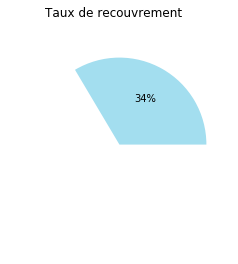

In [17]:
def Recouvrement(Compo):
    # fonction permettant de calculer le taux de recouvrement d'un fonds
    # Compo : tableau de composition du fonds et de son benchmark
    tauxRecouvrement=np.sum(Compo.min(axis=1))
    tauxRecouvrement=pd.DataFrame([tauxRecouvrement],columns={''})
    tauxRecouvrement.plot(kind="pie", autopct='%.f%%',subplots=True, colors=['#A3DEEF'], legend=False,labels=['',''],title='Taux de recouvrement')
    return tauxRecouvrement.values.item(0)

tauxRecouvrement = Recouvrement(Compo_Pf_CAC)

Le taux de recouvrement du fonds est de 34%, ce qui signifie que seulement un tiers du fonds ne recoupe le benchmark. Cela est caractéristique d'une gestion active. En effet, le portefeuille créé par une gestion passive aurait un taux de recouvrement avec son benchmark beaucoup plus élevé.

### Ratio d'investissement

La part de cash dans le fonds est de  6.0 %


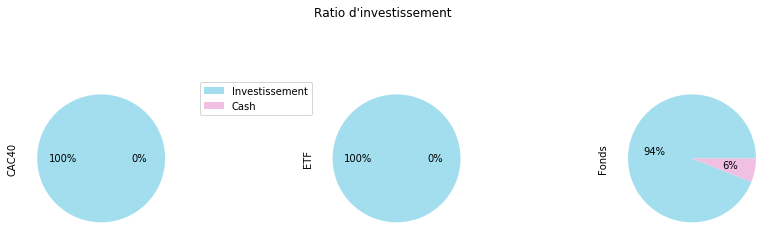

In [18]:
def RatioInv(Compo):
    # fonction permettant de calculer le taux d'investissement d'un fonds
    # Compo : tableau de composition du fonds et de son benchmark
    ratioInv=pd.DataFrame(round(Compo.sum(axis=0),2),columns={"Investissement"})
    ratioInv['Cash'] = 1-ratioInv["Investissement"]
    plots = ratioInv.T.plot(kind="pie",subplots=True, labels=['',''],colors=['#A3DEEF','#F1BFE2'],layout =(3,3),figsize=(15,10),title="Ratio d'investissement", autopct='%.f%%', legend = False)
    plots[0, 1].legend(loc='upper right', bbox_to_anchor= (0.0, 1.01), labels=ratioInv.T.index) # display legend and not labels so it's prettier
    return ratioInv
    
ratioInv = RatioInv(Compo_Pf_CAC)
print("La part de cash dans le fonds est de ",round(100 *ratioInv['Cash'][2],2),"%" )

### Régression multiple

In [19]:
listRiskFactors="Index_Sector"
listRiskFactors=compo[compo['Sector']==listRiskFactors]
listRiskFactors=listRiskFactors[["Name",'ISIN']]
listRiskFactors.drop_duplicates(inplace=True)
listRiskFactors = (listRiskFactors.Name + "-" + listRiskFactors.ISIN).tolist()

# Variable expliquée : les rendements du fonds
Y=Returns_Pf_CAC['Fonds']
X=Returns[listRiskFactors]
model = linear_model.LinearRegression()
results=model.fit(X,Y)
r2=results.score(X, Y)
coeffs=results.coef_

# Variable expliquée : les rendements du CACA40
Y=Returns_Pf_CAC['CAC40']
model2 = linear_model.LinearRegression()
results=model2.fit(X,Y)
r2Bmk=results.score(X, Y)
coeffsBmk=results.coef_

arr1 = np.append(coeffs,r2)
arr2 = np.append(coeffsBmk,r2Bmk)
results=pd.DataFrame(np.array([arr1,arr2]),columns=listRiskFactors+["RSquared"],index=["Fonds","CAC"])
results.columns.name = "Coefficients"
results=results.sort_values(by=['Fonds'], axis =1, ascending = False)
results

Coefficients,RSquared,Biens de consommation-QS0011017686,Industries-QS0011017652,Services aux consommateurs-QS0011017736,Technologie-QS0011017827,Sante-QS0011017702,Telecommunications-QS0011017769,Societes Financieres-QS0011017801,Petrole & Gaz-QS0011017603,Services aux collectivites-QS0011017785,Materiaux de base-QS0011017637
Fonds,0.941290,0.209568,0.207207,0.129996,0.128770,0.097992,0.068980,0.053488,0.048114,0.009003,-0.037865
CAC,0.991111,0.240428,0.222499,0.019694,0.008286,0.150345,0.035433,0.201597,0.114436,0.022894,0.065842


Ici, on cherche les secteurs les plus explicatifs des rendements du fonds comparés à ceux explicatifs des rendements du CAC40. On note que tous les secteurs contribuent positivement aux rendements du fonds et de l'indice, hormis le secteur "Materiaux de base" dont le coefficient est négatif dans la régression des rendements du fonds. 
Les coefficients des secteurs "Biens de consommation", "Industries" et  "Télécommunications" sont similaires pour les deux régressions.  En revanche, les coefficients associés aux secteurs "Services aux consommateurs", "Technologie" (qui sont tous les deux sur-pondérés par le fonds) contribuent davantage à expliquer les rendements du fonds que de l'indice.
Au contraire, les secteurs "Santé", "Societes Financieres", "Petrole & Gaz", "Services aux collectivites" et "Matérieux de base", qui sont sous-pondérés dans le fonds sont plus explicatifs des rendements du CAC40.

### Analyse du risque : volatilités et MCTR

#### Volatilités

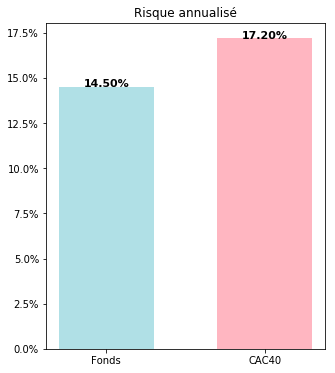

In [20]:
def Vol(Rendts,Freq=252):
    # fonction permettant de calculer la volatilité d'une série
    # Rendts : tableau de composition du fonds et de son benchmark
    # Freq (optionel) : fréquence utilisée pour le calcul de la vol (défaut : 252)
    return np.std(Rendts)*np.sqrt(Freq)

volPtf=Vol(Returns_Pf_CAC['Fonds']) # risque annualisé du portefeuille
volCAC=Vol(Returns_Pf_CAC['CAC40']) # risque annualisé du CAC40
FondsPlot(Fonds1 = volPtf*100, labelFonds1 = "Fonds", Fonds2 = volCAC*100, labelFonds2 = "CAC40",Titre="Risque annualisé")

Le fonds géré est moins volatile que son benchmark. Nous pouvons penser que ce fonds est plus défensif et moins aggressif.

#### MCTR

In [21]:
def MCTR(Compo, Fonds, Bench, Rendts, Freq = 252):
    # fonction permettant la création d'un tableau comportant la MCTR, la CTR, ainsi que les volatilité du fonds et de son benchmarks
    # Compo : tableau de composition du fonds et de son benchmark
    # Fonds : nom du fonds
    # Bench : nom du bench
    # Rendts : rendements des différents titres 
    # Freq (optionel) : fréquence utilisée pour le calcul de la vol (défaut : 252)
    volFondsCompo=np.sqrt(np.dot(np.dot(Compo[Fonds].T, Rendts.cov()), Compo[Fonds])*Freq)
    volBenchCompo=np.sqrt(np.dot(np.dot(Compo[Bench].T, Rendts.cov()), Compo[Bench])*Freq)
    Stats_Pf = Compo.copy()
    Stats_Pf["MCTR"]=1/volFondsCompo*(np.dot(Rendts.cov()*Freq,Compo[Fonds])) #contribution marginale à la vol du fonds de chaque actif
    Stats_Pf["CTR"]=Stats_Pf["MCTR"]*Stats_Pf[Fonds] #contribution à la vol du fonds de chaque actif
    Stats_Pf["VolFonds_VL"]=Vol(Returns_Pf_CAC[Fonds],Freq)
    Stats_Pf["VolFonds_Compos"]=volFondsCompo
    Stats_Pf["VolBench_VL"]=Vol(Returns_Pf_CAC[Bench],Freq)
    Stats_Pf["VolBench_Compos"]=volBenchCompo
    return Stats_Pf
    
MCTR_Ptf = MCTR(Compo_Pf_CAC,'Fonds','CAC40',Returns)
MCTR_Ptf.sort_values(by=['MCTR'], ascending=False).head(10)

Poids des actifs,CAC40,ETF,Fonds,MCTR,CTR,VolFonds_VL,VolFonds_Compos,VolBench_VL,VolBench_Compos
Security,,,,,,,,,
ArcelorMittal-LU1598757687,0.007996,NaN,0.000000,0.221847,0.000000,0.145034,0.145091,0.172003,0.170095
PEUGEOT SA-FR0000121501,0.008696,NaN,0.000000,0.210908,0.000000,0.145034,0.145091,0.172003,0.170095
STMICROELECTRONICS NV-NL0000226223,0.013293,NaN,0.000000,0.208616,0.000000,0.145034,0.145091,0.172003,0.170095
RENAULT SA-FR0000131906,0.005297,NaN,0.036654,0.205784,0.007543,0.145034,0.145091,0.172003,0.170095
SOCIETE GENERALE SA-FR0000130809,0.018691,NaN,0.000000,0.204891,0.000000,0.145034,0.145091,0.172003,0.170095
LVMH MOET HENNESSY LOUIS VUI-FR0000121014,0.086257,NaN,0.082378,0.201763,0.016621,0.145034,0.145091,0.172003,0.170095
CAP GEMINI-FR0000125338,0.013593,NaN,0.069530,0.190377,0.013237,0.145034,0.145091,0.172003,0.170095
KERING-FR0000121485,0.033083,NaN,0.000000,0.188991,0.000000,0.145034,0.145091,0.172003,0.170095
Airbus SE-NL0000235190,0.058271,NaN,0.000000,0.188421,0.000000,0.145034,0.145091,0.172003,0.170095


Si on tri le tableau ci-dessus par la MCTR (contribution marginale de chaque actif au risque du portefeuille), on remarque que sur les 10 actifs du CAC avec la MCTR la plus élevée, seulement 3 sont inclus dans le portefeuille (Renault, LVMH, Cap Gemini). Les 7 autres sont à 0. Le gérant a peut-être réalisé son allocation avec un objectif de réduire son risque en sous-pondérant les actifs ayant une contribution marginale élevée. En revanche, Cap Gemini est fortement sur-pondéré, le gérant doit donc avoir une conviction forte sur cette valeur.

### Risque systématique et risque spécifique

#### Bêta du fonds (régression simple)

R2 : 0.8940279083605873  Beta :  0.797278111624392  Alpha :  0.0001278837679258896


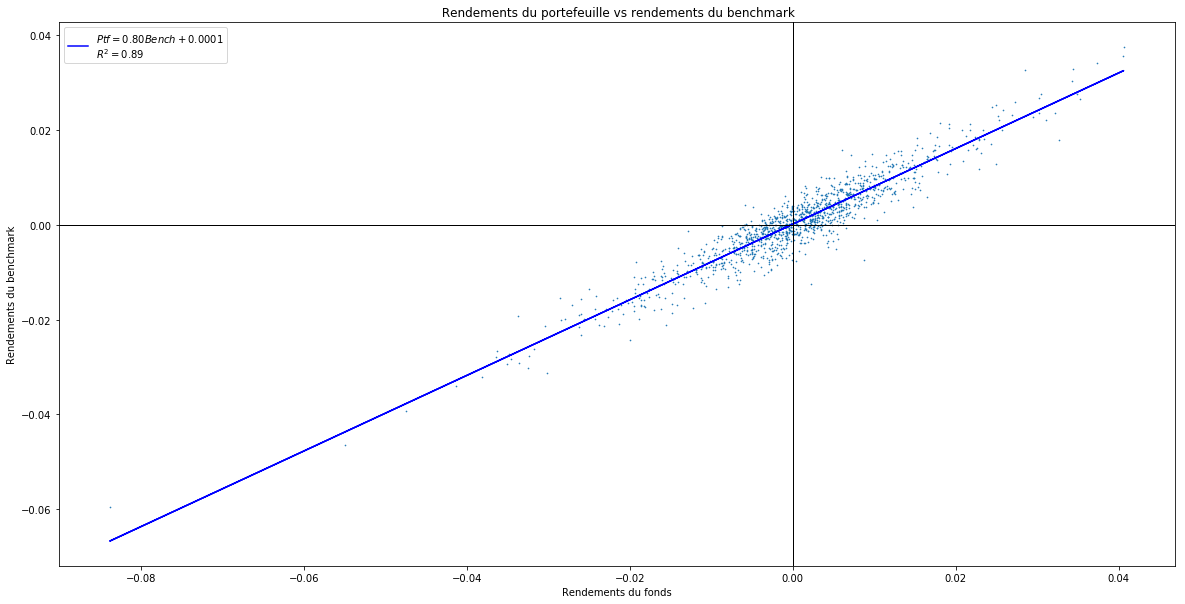

In [22]:
def Regression(Fund, Bench, Graph=True, Print=True):
    # fonction permettant de plot la regression des rendements du fonds sur ceux de son benchmark
    # et retourne un tableau comportant les résultats de la regression de X sur Y
    # Fund : rendements du fonds
    # Bench : rendements du benchmark
    # Graph (optionel) : permet à l'utilisateur d'afficher ou non le graphique (défaut à "true")
    # Print (optionel) : permet à l'utilisateur d'afficher ou non les résultats de la régression (défaut à "true")
    try: #reshape only if possible = if needed
        Fund=Fund.values.reshape(-1,1)
    except(AttributeError):
        pass
    try: #reshape only if possible = if needed
        Bench=Bench.values.reshape(-1,1)
    except(AttributeError):
        pass
    model = linear_model.LinearRegression()
    results=model.fit(Bench,Fund)
    # Etape 1 : tableau de la regression
    results_table={'r2':results.score(Bench, Fund),'beta':results.coef_.item(0),
                   'alpha':results.intercept_.item(0)}
    if Print:
        print("R2 :", results_table['r2'],  " Beta : ", results_table['beta'], " Alpha : ", results_table['alpha'])
    # Etape 2 : plot
    Fund_hat = results.coef_.item(0) * Bench + results.intercept_.item(0)
    if Graph:
        plt.figure(figsize=(20,10))
        plt.plot(Bench, Fund_hat, color = 'blue', label='$Ptf={0:.2f}Bench+{1:.4f}$\n$R^2 ={2:.2f}$'.
                 format(results.coef_.item(0),results.intercept_.item(0),results.score(Bench, Fund))) 
        plt.scatter(Bench,Fund, s=0.4)
        plt.axhline(y=0, color = "black", lw = 1)
        plt.axvline(x=0, color = "black", lw = 1)
        plt.xlabel("Rendements du fonds")
        plt.ylabel("Rendements du benchmark")
        plt.title(" Rendements du portefeuille vs rendements du benchmark")
        plt.legend(loc='best') 
    return results_table

pf_reg_results = Regression(Returns_Pf_CAC['Fonds'],Returns_Pf_CAC['CAC40'])

L'alpha de jensen est très faible (proche de 0) : le fonds ne surperforme par rapport à ce qui est prévu par le modèle. 
Sur l'ensemble de la période, le bêta du fonds est positif mais inférieur à 1 ce qui suggère que le fonds que les performances du fonds évoluent dans le même sens que celles du marchés, tout en restant plus défensive. 

Le nuage de points ne forme pas une droite ce qui est caractéristique d'une gestion active.  

In [23]:
def CovCor(Rendts, Fonds, Bench):
    # fonction permettant de retourner la covariance et corrélation des rendements d'un fonds et de son benchmark
    # Rendts : tableau de rendement du fonds et de son benchmark
    # Fonds : nom du fonds
    # Bench : nom du bench    
    Covariance = np.cov(Rendts[Fonds].T,Rendts[Bench].T)[0][1] #covariance des rendements
    Correlation = np.corrcoef(Rendts[Fonds].T,Rendts[Bench].T)[0][1] #corrélation entre les rendements
    return Covariance, Correlation

print("Covariance entre le fonds et son benchmark :", (CovCor(Returns_Pf_CAC,'Fonds','CAC40')[0]))
print("Corrélation entre le fonds et son benchmark :", (CovCor(Returns_Pf_CAC,'Fonds','CAC40')[1]).round(2)*100,"%")

Covariance entre le fonds et son benchmark : 9.367492051893004e-05
Corrélation entre le fonds et son benchmark : 95.0 %


La corrélation entre les rendements du fonds et de son benchmark est très élevée ce qui suggère que la relation affine entre les deux séries est plus importante que les variations internes des variables. Cela est cohérent avec le beta élevé.
Le fait que la corrélation soit si importante et que la covariance est presque nulle s'explique par la faiblesse des écart-types des deux séries. En effet, la covariance correspond au produit de la corrélation et des écart-types des deux séries de rendements. Or  les écart-types sont de l'odre de 10E-2 à 10E-3 (car ceux sont des rendements), le produit est donc de l'odre de 10E-5.

#### Risque systématique et risque spécifique

In [24]:
def Risk(Beta, Rendts, Freq=252):
    # fonction permettant de retourner un tableau de décomposition du risque du portefeuille (systématique/spécifique)
    # Beta : beta du fonds (corrélation au marché, cad à son bench) 
    # Rendts : série de rendement du fonds 
    # Freq (optionel) : fréquence utilisée pour les calculs (défaut : 252)
    totalRisk = np.std(Rendts)*np.sqrt(Freq)
    explainedX=Beta*Rendts.values
    nonExplainedX=Rendts.values-explainedX
    systematicRisk=np.std(explainedX)*np.sqrt(Freq)
    specificRisk=np.std(nonExplainedX)*np.sqrt(Freq)
    results_table={'Risque Total':totalRisk,'Risque Systématique':systematicRisk,
                   'Risque Spécifique':specificRisk, 'Part du risque diversifiable':specificRisk/totalRisk}
    print("Le fonds a une volatilité totale de ", (totalRisk*100).round(2),  
          "%, pouvant être décomposée en un risque systématique (", (systematicRisk*100).round(2),
          "%) et un risque spécifique (", (specificRisk*100).round(2), "%).")    
    return results_table

risq_pf = Risk(pf_reg_results['beta'],Returns_Pf_CAC['Fonds'])
risq_pf

Le fonds a une volatilité totale de  14.5 %, pouvant être décomposée en un risque systématique ( 11.56 %) et un risque spécifique ( 2.94 %).


{'Risque Total': 0.14503401338867514,
 'Risque Systématique': 0.11563244431582967,
 'Risque Spécifique': 0.029401569072845423,
 'Part du risque diversifiable': 0.2027218883756079}

Le risque systématique représente la majeure partie du risque du fonds. Seul 20% du risque est diversifiable.

### Analyse de la distribution des rendements du fonds

JBTEST - Rejet de H0 : pas de loi normale


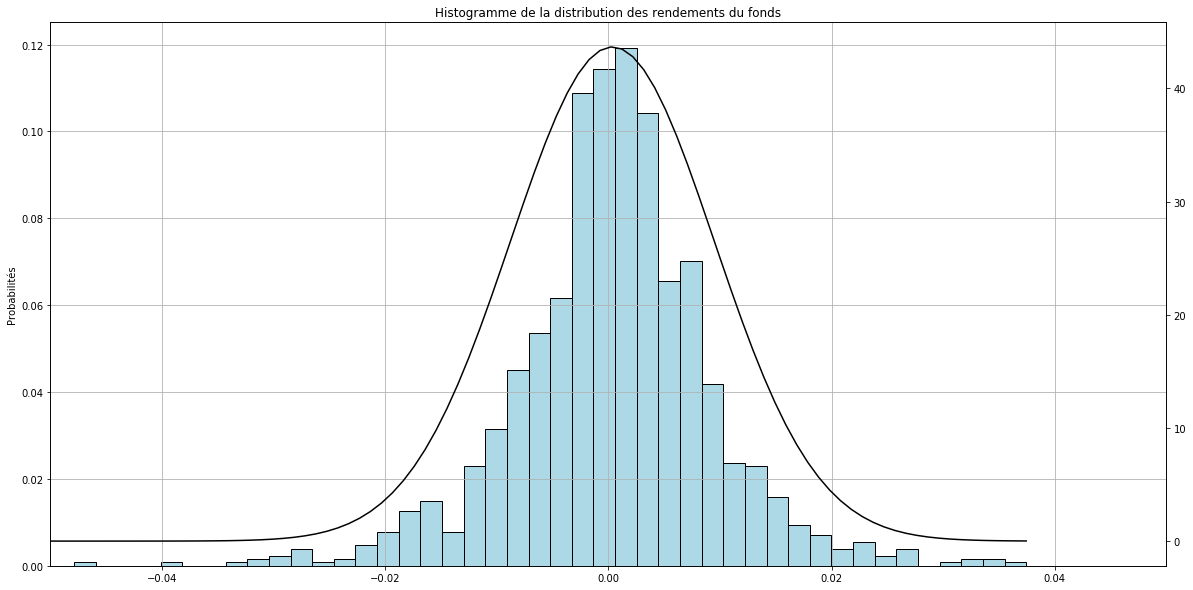

In [25]:
def DistribNormale(Rendts):
    # fonction permettant d'analyser un fonds afin de savoir s'il est normalement distribué
    # Rendts : rendements du fonds à analyser 
    # Etape 1 : test JB
    stat, p=jarque_bera(Rendts)
    if p>0.05:
        msg="JBTEST - Forte Présomption d'une loi normale"
    else:
        msg="JBTEST - Rejet de H0 : pas de loi normale"
    print(msg)
    
    # Etape 2 : plot
    n, bin_edges = np.histogram(Rendts.values, 50)
    bin_probability = n/float(n.sum()) # Normalize it, so that every bins value gives the probability of that bin
    bin_middles = (bin_edges[1:]+bin_edges[:-1])/2. # Get the mid points of every bin
    bin_width = bin_edges[1]-bin_edges[0]
    plt.figure(figsize=(20,10))
    plt.bar(bin_middles, bin_probability, width=bin_width, color="lightblue", edgecolor = "black")
    plt.grid(True)
    plt.xlim(-0.05,0.05)
    plt.ylabel('Probabilités')
    plt.title('Histogramme de la distribution des rendements du fonds')

    # courbe de densité normale
    x_max = np.max(Rendts.values)
    x_min = np.min(Rendts.values)
    x_mean = np.mean(Rendts.values)
    x_std = np.std(Rendts.values)
    x = np.linspace(x_min, x_max, 100)
    y = norm.pdf(x,x_mean,x_std)

    axes2 = plt.twinx()
    axes2.plot(x, y, color='k')
    plt.show()

DistribNormale(Returns_Pf_CAC['Fonds'])

### VaR

In [26]:
def VaRHistorique(Rendts, niveauConfiance=0.95, horizon=252):
    # fonction permettant le calcul de la VaR histo d'un fonds 
    # Rendts : rendements du fonds à analyser 
    # niveauConfiance : niveau de confiance utilisé (défaut : 0.95)
    # horizon (optionel) : horizon utilisée pour les calculs (défaut : 252)
    return np.quantile(Rendts, 1-niveauConfiance)*np.sqrt(horizon)

def VaRParametriqueNormale(Rendts, niveauConfiance=0.95, horizon=252):
    # fonction permettant le calcul de la VaR paramétrique d'un fonds 
    # Rendts : rendements du fonds à analyser 
    # niveauConfiance : niveau de confiance utilisé (défaut : 0.95)
    # horizon (optionel) : horizon utilisée pour les calculs (défaut : 252)
    return -np.std(Rendts)*norm.ppf(niveauConfiance)*np.sqrt(horizon)

def VaRMcNormale(Rendts, niveauConfiance=0.95, nbSimuls=1000, horizon=252):
    # fonction permettant le calcul de la VaR Monte Carlo d'un fonds 
    # Rendts : rendements du fonds à analyser 
    # nbSimuls : nombre de simulations (défaut : 1000)
    # niveauConfiance : niveau de confiance utilisé (défaut : 0.95)
    # horizon (optionel) : horizon utilisée pour les calculs (défaut : 252)
    x=np.random.rand(nbSimuls) #Simulation uniforme
    z=norm.ppf(x) # Transformation en Normale
    simuls=np.exp(np.std(Rendts)*z)-1
    return np.quantile(simuls, 1-niveauConfiance)*np.sqrt(horizon)

def VaRParametriqueStudent(Rendts, niveauConfiance=0.95, horizon=252):
    # fonction permettant le calcul de la VaR paramétrique avec loi de student d'un fonds 
    # Rendts : rendements du fonds à analyser 
    # niveauConfiance : niveau de confiance utilisé (défaut : 0.95)
    # horizon (optionel) : horizon utilisée pour les calculs (défaut : 252)
    nu, mu_t, sigma_t=t.fit(Rendts)
    mu_norm, sigma_norm=norm.fit(Rendts)
    return -(horizon*(nu-2)/nu)**0.5*t.ppf(niveauConfiance, nu)*sigma_norm

def VaRCornishFisher(Rendts, niveauConfiance=0.95, horizon=252):
    # fonction permettant le calcul de la VaR de cornish fisher d'un fonds 
    # Rendts : rendements du fonds à analyser 
    # niveauConfiance : niveau de confiance utilisé (défaut : 0.95)
    # horizon (optionel) : horizon utilisée pour les calculs (défaut : 252)
    mu, sigma, s, k = Rendts.mean(), Rendts.std(), skew(Rendts), kurtosis(Rendts)-3.0
    z=norm.ppf(niveauConfiance)
    zCf=z+s/6.0*(z**2-1)+k/24.0*z*(z**2-3.0)-s**2/36.0*z*(2.0*z**2-5.0)
    return (-zCf*sigma*np.sqrt(horizon)).item(0)

def CVaRParametriqueNormale(Rendts, niveauConfiance=0.95, horizon=252):
    # fonction permettant le calcul de la CVaR normale paramétrique d'un fonds 
    # Rendts : rendements du fonds à analyser 
    # niveauConfiance : niveau de confiance utilisé (défaut : 0.95)
    # horizon (optionel) : horizon utilisée pour les calculs (défaut : 252)
    return -np.std(Rendts)/(1-niveauConfiance)*norm.pdf(norm.ppf(niveauConfiance))*np.sqrt(horizon)

def CalculVaR(Rendts, niveauConfiance=0.95, nbSimuls=1000, horizon=252):
    # fonction permettant le calcul de toutes les Var d'un fonds (renvoie un tableau)
    # Rendts : rendements du fonds à analyser 
    # nbSimuls : nombre de simulations (défaut : 1000)
    # niveauConfiance : niveau de confiance utilisé (défaut : 0.95)
    # horizon (optionel) : horizon utilisée pour les calculs (défaut : 252)
    results_table={'VaR Histo':VaRHistorique(Rendts,niveauConfiance,horizon),
                   'VaR Param Norm':VaRParametriqueNormale(Rendts,niveauConfiance,horizon),
                   'VaR MC Norm':VaRMcNormale(Rendts,niveauConfiance,nbSimuls,horizon),
                   'VaR Param Stud':VaRParametriqueStudent(Rendts,niveauConfiance,horizon),
                   'CVaR Norm Param':CVaRParametriqueNormale(Returns_Pf_CAC['Fonds'].values,niveauConfiance, horizon),
                   'VaR Cornish Fisher':VaRCornishFisher(Rendts,niveauConfiance,horizon),
                  }
    return results_table

var_pf=CalculVaR(Returns_Pf_CAC['Fonds'].values)
var_pf

{'VaR Histo': -0.2431780638787796,
 'VaR Param Norm': -0.23855972295369057,
 'VaR MC Norm': -0.2409317713346469,
 'VaR Param Stud': -0.215286356347413,
 'CVaR Norm Param': -0.29916351694102356,
 'VaR Cornish Fisher': -0.2209630690480336}

#### Backtesting de la VaR

In [27]:
def BackTestVaR(Rendts, horizonGlissante=252, niveauConfiance=0.95, fctVaR=VaRParametriqueNormale,riskLevel = 0.05):
    # fonction tirée de la section 1 du cours (permetant le backtest de la VaR)
    vaR=Rendts.rolling(window=horizonGlissante).apply(lambda x:(fctVaR(x, niveauConfiance)/np.sqrt(252)), raw=True)
    data=np.column_stack((Rendts, vaR, Rendts<vaR))
    mask = np.any(np.isnan(data), axis=1) #Suppression des nan
    data=data[~mask]
    nbTotalPoints=len(data)
    nbBreach=np.sum(Rendts<vaR)
    pctBreach=nbBreach/nbTotalPoints
    test=binom_test(x=nbBreach, n=nbTotalPoints, p=riskLevel)
    if test>riskLevel:
        result="Rejet H0"
    else:
        result="Acceptation H0"
    results_table = {'Breach':nbBreach,'pctBreach':pctBreach,'Result':result,'riskLevel':riskLevel}
    return results_table
    
pf_var_backtest = BackTestVaR(Returns_Pf_CAC['Fonds'])
print(f"{pf_var_backtest['Result']} pour un niveau de confiance à {pf_var_backtest['riskLevel']*100}%. Breach : {round(pf_var_backtest['pctBreach']*100,2)}%")
pf_var_backtest = BackTestVaR(Returns_Pf_CAC['Fonds'],fctVaR=VaRHistorique)
print(f"{pf_var_backtest['Result']} pour un niveau de confiance à {pf_var_backtest['riskLevel']*100}%. Breach : {round(pf_var_backtest['pctBreach']*100,2)}%")

Rejet H0 pour un niveau de confiance à 5.0%. Breach : 4.33%
Rejet H0 pour un niveau de confiance à 5.0%. Breach : 4.53%


Pour un niveau de confiance à 95%, on obtient un pourcentage de Hits de la VaR historique de 4.53%. Cette valeur est proche du 5% de notre niveau de risque mais n'est pas plus grande. Le calcul de VaR est donc valide et peut être utilisé dans un objectif de gestion des risques.

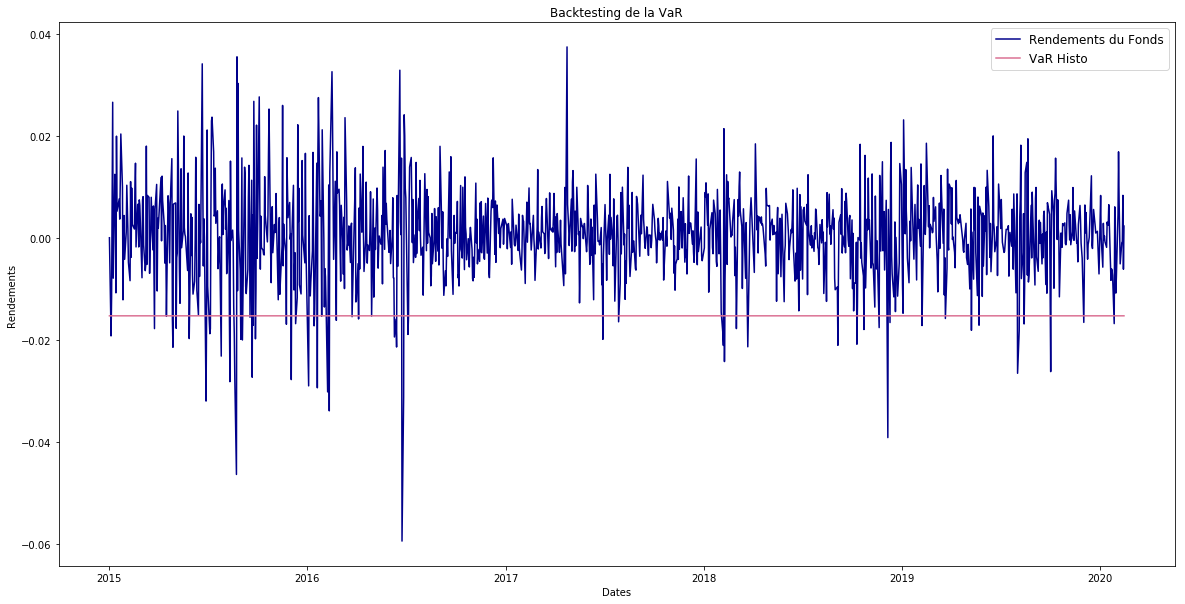

In [28]:
def VaRPlot(Dates, Rendts, niveauConfiance=0.95, horizon=252):
    # fonction permettant de plot la VaR histo d'un fonds et ses rendements afin de backtester
    # fonction permettant le calcul de toutes les Var d'un fonds (renvoie un tableau)
    # Rendts : rendements du fonds à analyser 
    # niveauConfiance : niveau de confiance utilisé (défaut : 0.95)
    # horizon (optionel) : horizon utilisée pour les calculs (défaut : 252)
    plt.figure(figsize=(20,10))
    plt.plot(pd.to_datetime(Dates), Rendts, color="darkblue", label ="Rendements du Fonds")
    plt.plot(pd.to_datetime(Dates), np.ones(len(Rendts))*VaRHistorique(Rendts.values, niveauConfiance, horizon), color="palevioletred", label = "VaR Histo")
    plt.xlabel("Dates")
    plt.ylabel("Rendements")
    plt.title("Backtesting de la VaR")
    plt.legend(loc='best',fontsize=12)
    plt.show
VaRPlot(Returns_Pf_CAC['Fonds'].index,Returns_Pf_CAC['Fonds'],horizon=1)

## Etape 2 - Analyse de la performance de l'ETF par rapport au benchmark 

### Analyse de la performance

#### Cours de l'ETF et de son perf index en base 100 

In [29]:
Prices_ETF_CACS = Fonds(Compo_Pf_CAC['ETF'], Returns, "PrixBase100", Bench='CAC40Shortx1')
Prices_ETF_CACS.head(5)

Prix base 100,Fonds,CAC40Shortx1
date,,
2015-01-02,100.000000,100.000000
2015-01-05,103.261478,103.165007
2015-01-06,103.933371,103.884851
2015-01-07,103.261478,103.231729
2015-01-08,99.468085,99.450486


#### Cours de l'ETF et du CAC40 en base 100 

In [30]:
Prices_ETF_CAC = Fonds(Compo_Pf_CAC['ETF'], Returns, "PrixBase100", Bench='CAC40')
Prices_ETF_CAC.head(5)

Prix base 100,Fonds,CAC40
date,,
2015-01-02,100.000000,100.000000
2015-01-05,103.261478,96.685786
2015-01-06,103.933371,96.030609
2015-01-07,103.261478,96.718004
2015-01-08,99.468085,100.185782


#### Performance de l'ETF

La performance totale de l'ETF est :  -52.18 %
La performance totale du benchmark est :  -42.77 %


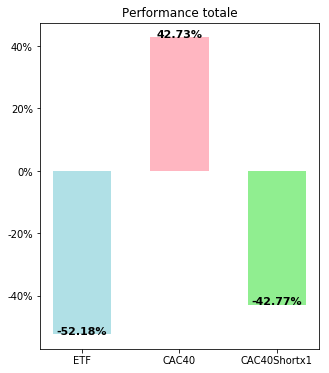

In [31]:
perfTotaleETF = PerfTot(Prices_ETF_CACS["Fonds"])
print("La performance totale de l'ETF est : ", (perfTotaleETF *100).round(2), "%")
perfTotaleBenchETF = PerfTot(Prices_ETF_CACS["CAC40Shortx1"])
print("La performance totale du benchmark est : ", (perfTotaleBenchETF *100).round(2), "%")
FondsPlot(perfTotaleETF*100,"ETF",Fonds2 = perfTotaleBench*100,labelFonds2 = "CAC40",Fonds3 = perfTotaleBenchETF*100,labelFonds3 = "CAC40Shortx1")

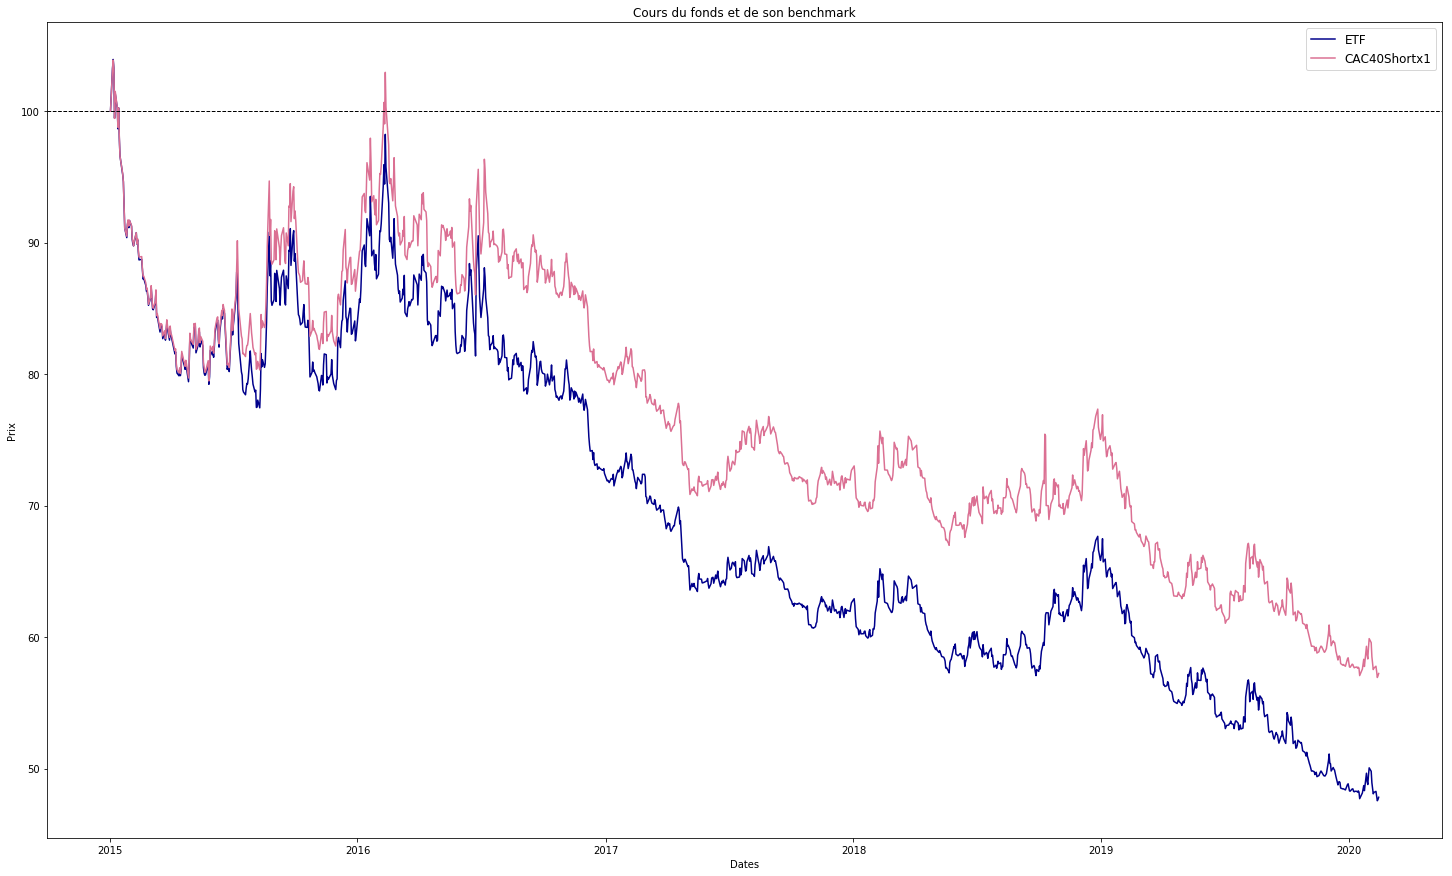

In [32]:
PlotPerf(Prices_ETF_CACS.index, Prices_ETF_CACS['Fonds'], Prices_ETF_CACS['CAC40Shortx1'],'ETF','CAC40Shortx1')

Sur l'ensemble de la période, la performance de l'ETF est toujours inférieure ou égale à celle de son perfomance index, le CAC40 Short x1.

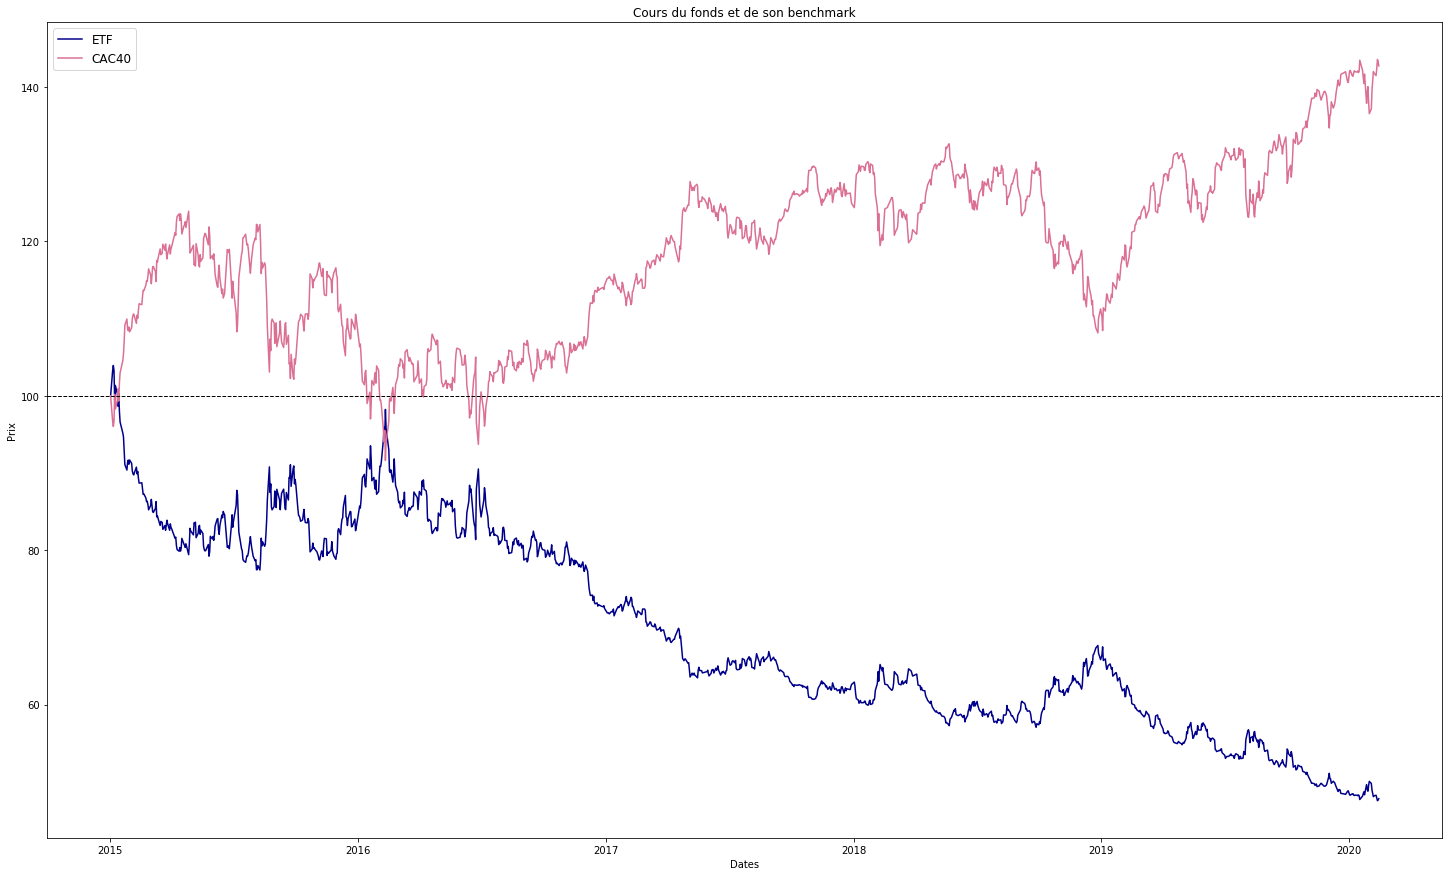

In [33]:
PlotPerf(Prices_ETF_CAC.index, Prices_ETF_CAC['Fonds'], Prices_ETF_CAC['CAC40'],'ETF','CAC40')

Sur l'ensemble de la période, l'ETF semble répliquer l'inverse de la performance du CAC40, et sous-performe son benchmark. 

#### Rendements de l'ETF et son perf index

In [34]:
Returns_ETF_CACS = Fonds(Compo_Pf_CAC['ETF'], Returns, "Rendements", Bench='CAC40Shortx1')
Returns_ETF_CACS.head(4)

Rendements,Fonds,CAC40Shortx1,Relatif,Cuml
date,,,,
2015-01-02,0.000000,0.000000,0.000000,100.000000
2015-01-05,0.032094,0.031160,0.000935,100.093468
2015-01-06,0.006486,0.006953,-0.000468,100.046651
2015-01-07,-0.006486,-0.006307,-0.000179,100.028762


Tracking error annualisée (ETF vs CAC40 Short x1) :  4.83 %


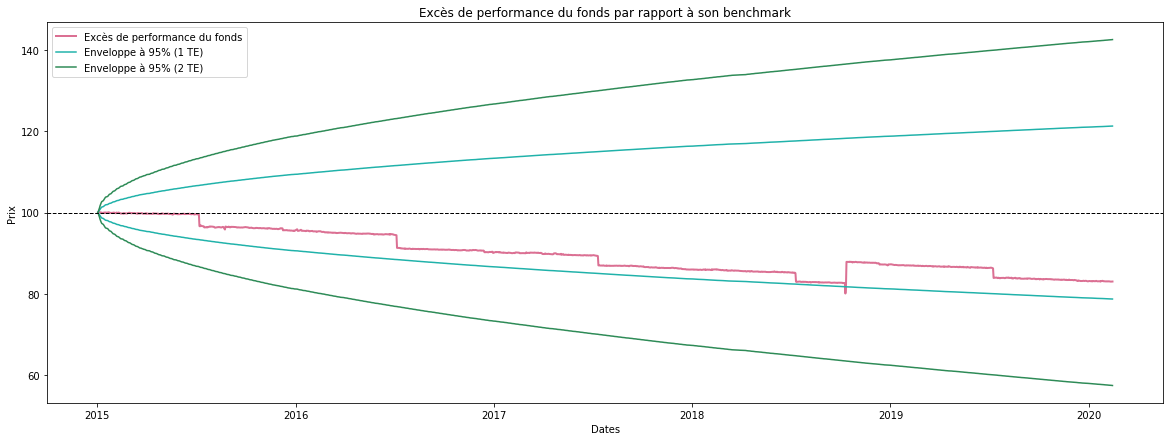

In [35]:
teETFS=TEexcPerf(Returns_ETF_CACS) 
print("Tracking error annualisée (ETF vs CAC40 Short x1) : ", (teETFS *100).round(2), "%")

La tracking error est supérieure à 2%, le fonds analysé est donc géré activement comparé au CAC40 Short x1. Cela est étrange pour un ETF (gestion passive). 

#### Rendements de l'ETF et du CAC40

In [36]:
Returns_ETF_CAC = Fonds(Compo_Pf_CAC['ETF'], Returns, "Rendements", Bench='CAC40', Short=True)
Returns_ETF_CAC.head(4)

Rendements,Fonds,CAC40,Relatif,Cuml
date,,,,
2015-01-02,0.000000,0.000000,-0.000000,100.000000
2015-01-05,0.032094,-0.033704,0.001610,100.160958
2015-01-06,0.006486,-0.006799,0.000314,100.192386
2015-01-07,-0.006486,0.007133,-0.000647,100.127567


In [37]:
teETF=TEexcPerf(Returns_ETF_CAC, Graph=False) 
print("Tracking error annualisée (ETF vs CAC40) : ", (teETF *100).round(2), "%")

Tracking error annualisée (ETF vs CAC40) :  1.26 %


La tracking error est inférieure à 2%, l'ETF est donc géré passivement (comparé au CAC40). Cependant, l'ETF est sensé répliquer à l'inverse les rendements du CAC40 GR et non ceux du CAC40.

### Analyse du risque

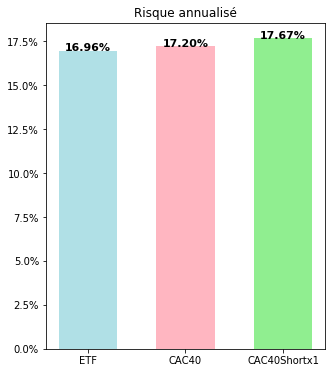

In [38]:
volETF=Vol(Returns_ETF_CACS['Fonds']) # risque annualisé du portefeuille
volCACS=Vol(Returns_ETF_CACS['CAC40Shortx1']) # risque annualisé du CAC40 Short x1
FondsPlot(Fonds1 = volETF*100, labelFonds1 = "ETF", Fonds2 = volCAC*100, labelFonds2 = "CAC40", Fonds3 = volCACS*100, labelFonds3 = "CAC40Shortx1",Titre="Risque annualisé")

L'ETF possède une volatilité de 17% (de même que le CAC40), légèrement plus faible que celle du CAC40 Short x1 (18%). L'ETF possède donc une plus grande volatilité que le fonds étudié (15%).

### Analyse de la corrélation au CAC40Shortx1 + risque systématique et risque spécifique

#### Bêta de l'ETF en utilisant le CAC40Shortx1 comme benchmark

R2 : 0.9251908830862121  Beta :  0.9231612339285971  Alpha :  -0.0001757129801761217


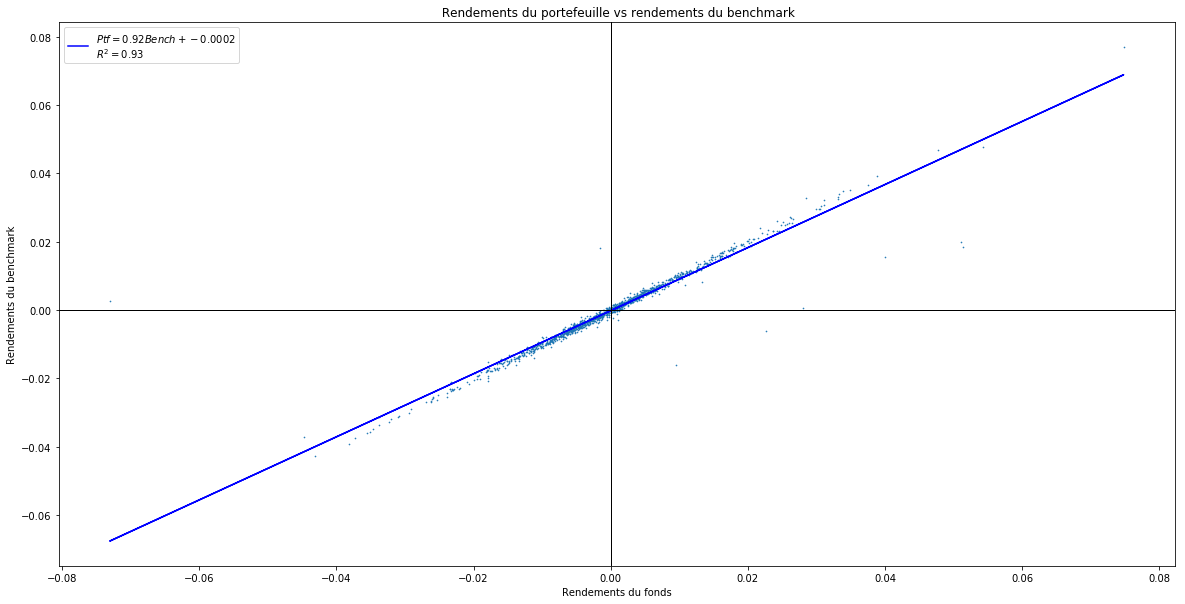

In [39]:
etf_reg_results_s = Regression(Returns_ETF_CACS['Fonds'],Returns_ETF_CACS['CAC40Shortx1'])

#### Corrélations et covariances

In [40]:
print("Covariance entre l'ETF et le CAC40Shortx1 :", (CovCor(Returns_ETF_CACS,'Fonds','CAC40Shortx1')[0]).round(2),"%")
print("Corrélation entre l'ETF et le CAC40Shortx1 :", (CovCor(Returns_ETF_CACS,'Fonds','CAC40Shortx1')[1]).round(2),"%")

Covariance entre l'ETF et le CAC40Shortx1 : 0.0 %
Corrélation entre l'ETF et le CAC40Shortx1 : 0.96 %


L'ETF est très fortement corrélé au CAC40 Short x1.

#### Décomposition du risque

In [41]:
risq_etf_s = Risk(etf_reg_results_s['beta'],Returns_ETF_CACS['Fonds'])
risq_etf_s

Le fonds a une volatilité totale de  16.96 %, pouvant être décomposée en un risque systématique ( 15.66 %) et un risque spécifique ( 1.3 %).


{'Risque Total': 0.16958333901924838,
 'Risque Systématique': 0.15655276450274103,
 'Risque Spécifique': 0.01303057451650745,
 'Part du risque diversifiable': 0.07683876607140297}

Le risque est essentiellement systématique, ce qui est logique puisqu'il s'agit d'un fond répliquant l'indice à l'inverse.

### Analyse de la corrélation au CAC40 + risque systématique et risque spécifique

#### Bêta de l'ETF en utilisant le CAC40 comme benchmark

R2 : 0.9947962727280113  Beta :  -0.9833648826052591  Alpha :  -0.0003061778896698019


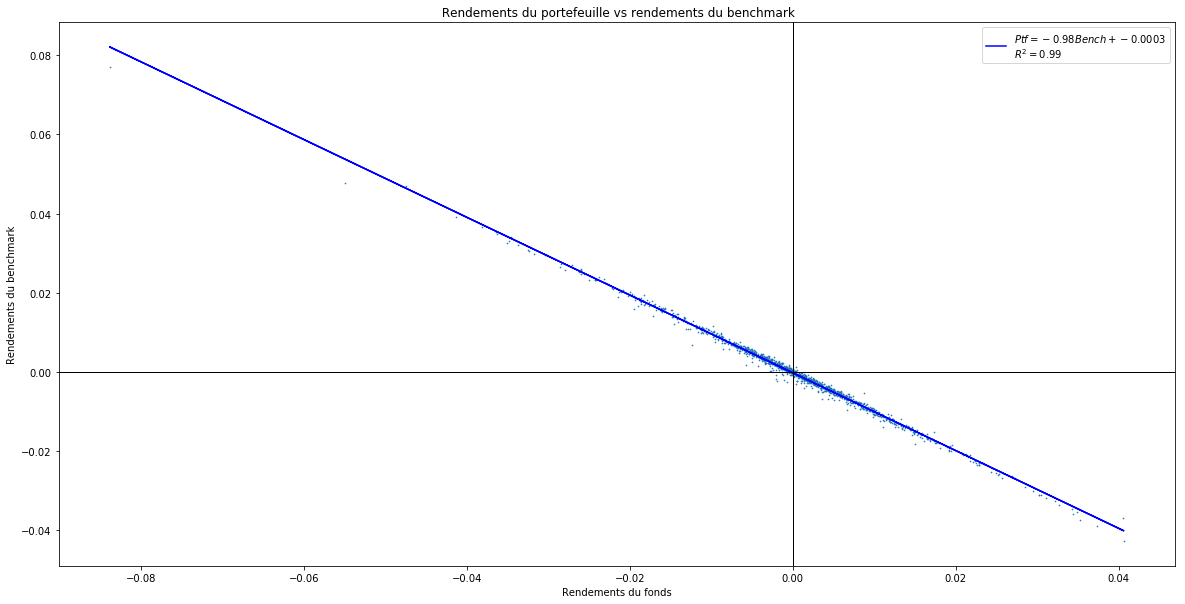

In [42]:
etf_reg_results = Regression(Returns_ETF_CAC['Fonds'],Returns_ETF_CAC['CAC40'])

Les rendements de l'ETF correspondent à 98% aux rendements du benchmark. 

#### Corrélation et covariance

In [43]:
print("Covariance entre l'ETF et le CAC40 :", (CovCor(Returns_ETF_CAC,'Fonds','CAC40')[0]).round(2),"%")
print("Corrélation entre l'ETF et le CAC40 :", (CovCor(Returns_ETF_CAC,'Fonds','CAC40')[1]).round(2),"%")

Covariance entre l'ETF et le CAC40 : -0.0 %
Corrélation entre l'ETF et le CAC40 : -1.0 %


On observe une corrélation parfaite entre l'ETF et le CAC40. L'ETF semble répliquer à l'inverse le CAC 40. Cependant, le prospectus promet une réplication inverse du CAC 40 GR ! 

#### Décomposition du risque

In [44]:
risq_etf = Risk(etf_reg_results['beta'],Returns_ETF_CAC['Fonds'])
risq_etf

Le fonds a une volatilité totale de  16.96 %, pouvant être décomposée en un risque systématique ( 16.68 %) et un risque spécifique ( 33.63 %).


{'Risque Total': 0.16958333901924838,
 'Risque Systématique': 0.16676230026647113,
 'Risque Spécifique': 0.3363456392857196,
 'Part du risque diversifiable': 1.9833648826052601}

### Conclusions sur l'analyse de la performance et du risque de l'indice

Les résultats obtenus ne sont pas cohérents avec la documentation du fonds : le Lyxor CAC 40 Daily (-1x) Inverse réplique à l'inverse le CAC 40 et a donc des performance contraires à celui-ci, sans pour autant avoir des performances exactement inverse en raison d'un réajustement quotidien du levier effectué dans l’indice de référence. Le prospectus promet, cependant, une réplication inverse du CAC 40 GR (Gross Return : dividendes réinvestis).

### Analyse de la distribution des rendements de l'ETF

JBTEST - Rejet de H0 : pas de loi normale


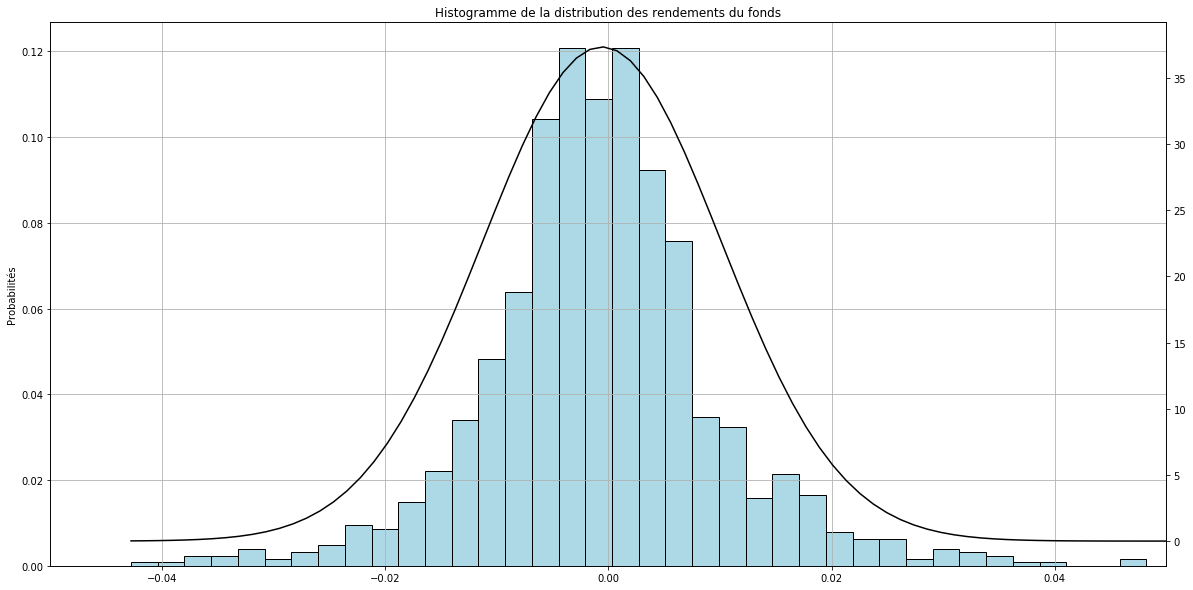

In [45]:
DistribNormale(Returns_ETF_CAC['Fonds'])

## Etape 3 - Analyse de l'impact de l'ajout de l'ETF au fonds initial

In [46]:
w_cash_init = ratioInv['Cash'][2] # part du cash dans le pf initial
print(f"Cash disponible : {round(w_cash_init*100,2)}%.")

Cash disponible : 6.0%.


In [47]:
Compo_hedge = pd.DataFrame() #dataFrame qui contiendra les compositions des portefeuilles de couverture à 5%
def VaR(Rendts): 
    # fonction permettant de retourner la VaR (95%, 252j) histo d'un fonds (horizon 1 an, niveau de confiance 95%)
    # Rendts : rendements du fonds à analyser 
    return VaRHistorique(Rendts)
def Volat(Rendts):
    # fonction permettant de retourner la vol 1 an d'un fonds
    # Rendts : rendements du fonds à analyser 
    return Vol(Rendts)
def Beta(Rendts): 
    # fonction permettant de retourner le beta d'un fonds
    # Rendts : rendements du fonds à analyser 
    return Regression(Rendts, Returns_Pf_CAC['CAC40'],Graph=False,Print=False)['beta']

def Get_stat_adding_w_ETF(w,func): 
    # fonction permettant le recalcul de VaR, Vol ou Béta (à la suite de l'injection de l'ETF)
    # w : poids de l'ETF 
    # func : fonction à utiliser (VaR, Volat ou Beta)
    # Etape 1 : recalculer les returns
    Compo_hedge['Fonds_'+func.__name__] = Compo_Pf_CAC['Fonds']
    Compo_hedge['Fonds_'+func.__name__].iloc[np.where(Compo_Pf_CAC.index.str.endswith('FR0010591362') == True)[0]] = w 
    Returns_Pf=Compo_hedge['Fonds_'+func.__name__].T*Returns
    Returns_Pf=Returns_Pf.sum(axis=1)
    Returns_Pf=pd.DataFrame(data=Returns_Pf, columns={"Fonds"})
    #Etape 2 : calculer la VaR, Vol ou Béta
    res = func(Returns_Pf.values)
    return res

# fonction d'optimisation de la VaR, Vol ou Béta en trouvant le poids w optimal de l'ETF à injecter
def Optimise_stat_adding_w_ETF(w,func,cible):
    # fonction permettant une optimisatio de VaR, Vol ou Béta (pour déterminer le poids de l'ETF)
    # w : poids de l'ETF 
    # func : fonction à optimiser (VaR, Volat ou Beta)
    # cible : cible de VaR, Volat ou Beta à atteindre
    # Etape 1 : faire varier le poids de l'ETF 
    Compo_hedge['Fonds_'+func.__name__] = Compo_Pf_CAC['Fonds']
    Compo_hedge['Fonds_'+func.__name__].iloc[np.where(Compo_Pf_CAC.index.str.endswith('FR0010591362') == True)[0]] = w 
    Returns_Pf=Compo_hedge['Fonds_'+func.__name__].T*Returns
    Returns_Pf=Returns_Pf.sum(axis=1)
    Returns_Pf=pd.DataFrame(data=Returns_Pf, columns={"Fonds"})
    #Etape 2 : calculer la VaR, Vol ou Béta
    res=func(Returns_Pf.values)
    return abs(res - cible)

### Création de 3 portefeuilles permettant de réduire respectivement la VaR, la volatilité ou le beta de 5%

Pour répondre à la demande du client, nous définissons 3 portefeuilles qui permettent d’addresser le besoin de “se couvrir à 5%”. Chaque portefeuille diminue de 5% une métrique distincte : la VaR historique, la volatilité et le bêta. Nous conserverons le portefeuille permettant de conserver les rendements les plus élevés. 

#### Portefeuille 1 - Fonds_VaR : réduction de la VaR historique de 5% ( résultat : 3.96% d'ETF à injecter)

In [48]:
VaR_cible = 0.95 * var_pf['VaR Histo']
print("VaR avant injection de l'ETF :", (var_pf['VaR Histo']*100).round(2),"%")
print("VaR cible (avec injection de l'ETF) : ", (VaR_cible*100).round(2),"%")

VaR avant injection de l'ETF : -24.32 %
VaR cible (avec injection de l'ETF) :  -23.1 %


In [49]:
w_opt_var = spo.fminbound(func=Optimise_stat_adding_w_ETF, x1=0, x2=w_cash_init,args=(VaR,VaR_cible)) # poids à 3.96% dans l'ETF
print("Le poids de l'ETF à ajouter pour une réduction de 5% de la VaR est ", (w_opt_var *100).round(2),
      "%. Ce qui réduirait la VaR (95%, 1j) à ", (Get_stat_adding_w_ETF(w_opt_var,VaR)*100).round(2),"%.")

Le poids de l'ETF à ajouter pour une réduction de 5% de la VaR est  3.96 %. Ce qui réduirait la VaR (95%, 1j) à  -23.1 %.


#### Portefeuille 2 - Fonds_Vol : réduction de la volatilité de 5% (résultat : 4.54% d'ETF à injecter)

In [50]:
vol_cible = 0.95*volPtf
print("Volatilité avant injection de l'ETF :", round(volPtf*100,2),"%")
print("Volatilité cible (avec injection de l'ETF) : ", round(vol_cible*100,2),"%")

Volatilité avant injection de l'ETF : 14.5 %
Volatilité cible (avec injection de l'ETF) :  13.78 %


In [51]:
w_opt_vol = spo.fminbound(func=Optimise_stat_adding_w_ETF, x1=0, x2=w_cash_init,args=(Vol,vol_cible)) # poids à 4.54% dans l'ETF
print(f"Le poids de l'ETF à ajouter pour une réduction de 5% de la volatilité est {(w_opt_vol *100).round(2)}%. Ce qui réduirait la volatilité à {(Get_stat_adding_w_ETF(w_opt_vol,Vol)*100).round(2)}%.")

Le poids de l'ETF à ajouter pour une réduction de 5% de la volatilité est 4.54%. Ce qui réduirait la volatilité à 13.78%.


#### Portefeuille 3 - Fonds_Beta : réduction du beta de 5% (résultat : 4.05% d'ETF à injecter)

In [52]:
beta_cible = 0.95*pf_reg_results['beta']
print("Beta avant injection de l'ETF :", round(pf_reg_results['beta'],2))
print("Beta cible (avec injection de l'ETF) : ", round(beta_cible,2))

Beta avant injection de l'ETF : 0.8
Beta cible (avec injection de l'ETF) :  0.76


In [53]:
w_opt_beta = spo.fminbound(func=Optimise_stat_adding_w_ETF, x1=0, x2=w_cash_init,args=(Beta,beta_cible)) # poids à 4.05% dans l'ETF
print(f"Le poids de l'ETF à ajouter pour une réduction de 5% du beta est {round(w_opt_beta *100,2)}%. Ce qui réduirait le beta à {round(Get_stat_adding_w_ETF(w_opt_beta,Beta),2)}.")

Le poids de l'ETF à ajouter pour une réduction de 5% du beta est 4.05%. Ce qui réduirait le beta à 0.76.


Nous obtenons donc 3 portefeuilles avec des investissements dans l'ETF distincts, mais permettant chacun de réduire une métrique de risque de 5%. Nous cherchons maintenant à déterminer quel portefeuille conserver. 

### Analyses de ces 3 portefeuilles et comparaison avec le portefeuille initial

#### Sauvegarde des prix, prix rebasés et rendements des 3 portefeuilles, du portefeuille initial et du bench sur les 3 dernières années

In [54]:
Yminus3 = "2017-02-13" # analyse sur les 3 dernières années 

In [55]:
def TabHedg(Analyse, Rendts, Relatifs = False):
    # fonction permettant la création d'un tableau des séries de rdt, prix, des fonds hedgés + fonds initial + CAC40
    # Analyse : type d'analyse à appliquer (en Prix, Rendements ou PrixBase100)  
    # Rendts : df des rendements des actifs du marché    
    # Relatifs (optionel) : permet de retourner les rendements relatifs (vs CAC40) (défaut à false)   
    if Relatifs:
        Hedge_initial_bench = Fonds(Compo_hedge['Fonds_VaR'], Rendts, Analyse, StartDate = Yminus3, Bench = "CAC40").drop(['CAC40'],axis=1)
        Hedge_initial_bench = Hedge_initial_bench.join(Fonds(Compo_hedge['Fonds_Vol'], Rendts, Analyse, StartDate = Yminus3, Bench = "CAC40").drop(['CAC40'],axis=1),lsuffix="_VaR",rsuffix="_Vol")
        Hedge_initial_bench = Hedge_initial_bench.join(Fonds(Compo_hedge['Fonds_Beta'], Rendts, Analyse, StartDate = Yminus3, Bench = "CAC40").drop(['CAC40'],axis=1))
    else:
        Hedge_initial_bench = Fonds(Compo_hedge['Fonds_VaR'], Rendts, Analyse, StartDate = Yminus3)
        Hedge_initial_bench = Hedge_initial_bench.join(Fonds(Compo_hedge['Fonds_Vol'], Rendts, Analyse, StartDate = Yminus3),lsuffix="_VaR",rsuffix="_Vol")
        Hedge_initial_bench = Hedge_initial_bench.join(Fonds(Compo_hedge['Fonds_Beta'], Rendts, Analyse, StartDate = Yminus3))
    Hedge_initial_bench = Hedge_initial_bench.join(Fonds(Compo_Pf_CAC['Fonds'], Rendts, Analyse, StartDate = Yminus3, Bench = "CAC40"),lsuffix='_Beta',rsuffix='_initial')
    return Hedge_initial_bench

Prices_rebased_hedge_initial_bench = TabHedg("PrixBase100", Returns)
Prices_rebased_hedge_initial_bench.head(4)

,Fonds_VaR,Fonds_Vol,Fonds_Beta,Fonds_initial,CAC40
date,,,,,
2017-02-13,100.000000,100.000000,100.000000,100.000000,100.000000
2017-02-14,100.646852,100.645497,100.646626,100.656211,100.156090
2017-02-15,100.948960,100.946242,100.948506,100.967743,100.750175
2017-02-16,101.173050,101.170868,101.172686,101.188128,100.230556


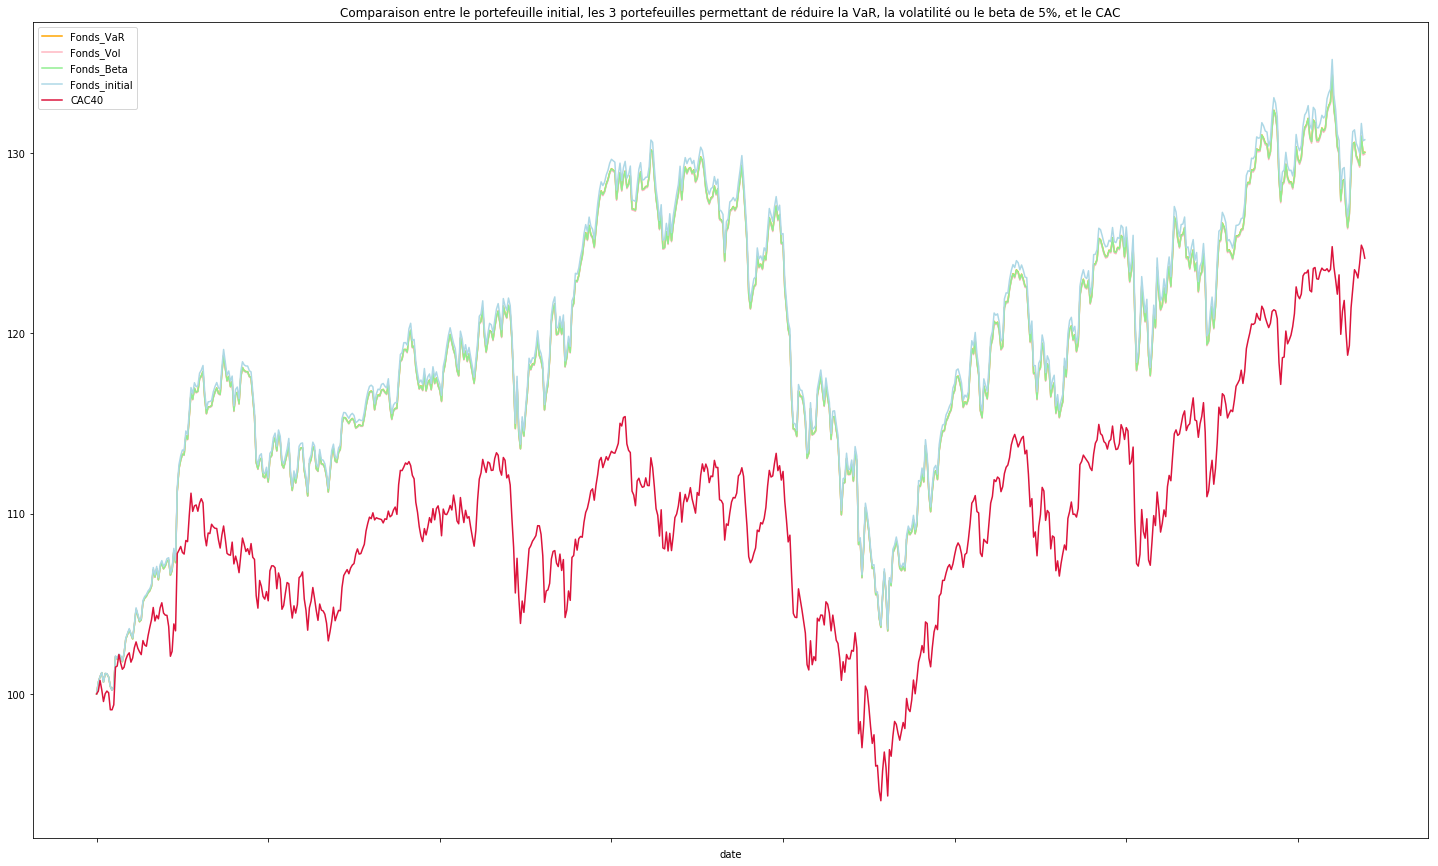

In [56]:
Prices_rebased_hedge_initial_bench.plot(title='Comparaison entre le portefeuille initial, les 3 portefeuilles permettant de réduire la VaR, la volatilité ou le beta de 5%, et le CAC', figsize=(25,15),color=("orange","lightpink","lightgreen","lightblue","crimson"))

Nous n'observons pas de différence notable entre la performance des trois fonds avec une part d'ETF et la performance du fonds initial sans ETF. La performance reste, sur l'ensemble de la période, supérieure où égale à celle du benchmark (CAC 40).

In [57]:
Prices_hedge_initial_bench = TabHedg("Prix", Returns)
Prices_hedge_initial_bench.head(4)

,Fonds_VaR,Fonds_Vol,Fonds_Beta,Fonds_initial,CAC40
date,,,,,
2017-02-13,94.459822,94.608594,94.484625,93.444244,4888.19
2017-02-14,95.070837,95.219290,95.095586,94.057435,4895.82
2017-02-15,95.356208,95.503821,95.380817,94.348544,4924.86
2017-02-16,95.567883,95.716336,95.592632,94.554481,4899.46


In [58]:
Rdt_hedge_initial_bench = TabHedg("Rendements", Returns, Relatifs = True)
Rdt_hedge_initial_bench.head(4)

Rendements,Fonds_VaR,Relatif_VaR,Cuml_VaR,Fonds_Vol,Relatif_Vol,Cuml_Vol,Fonds_Beta,Relatif_Beta,Cuml_Beta,Fonds_initial,CAC40,Relatif_initial,Cuml_initial
date,,,,,,,,,,,,,
2017-02-13,0.009292,-0.003032,99.696828,0.009222,-0.003101,99.689868,0.009280,-0.003043,99.695668,0.009767,0.012324,-0.002557,99.744338
2017-02-14,0.002669,0.001109,99.807397,0.002656,0.001097,99.799190,0.002667,0.001107,99.806029,0.002754,0.001560,0.001194,99.863427
2017-02-15,0.002598,-0.003316,99.476465,0.002565,-0.003349,99.465001,0.002593,-0.003321,99.474554,0.002823,0.005914,-0.003091,99.554747
2017-02-16,0.000939,0.006110,100.084239,0.000972,0.006143,100.075978,0.000944,0.006115,100.082862,0.000714,-0.005171,0.005885,100.140631


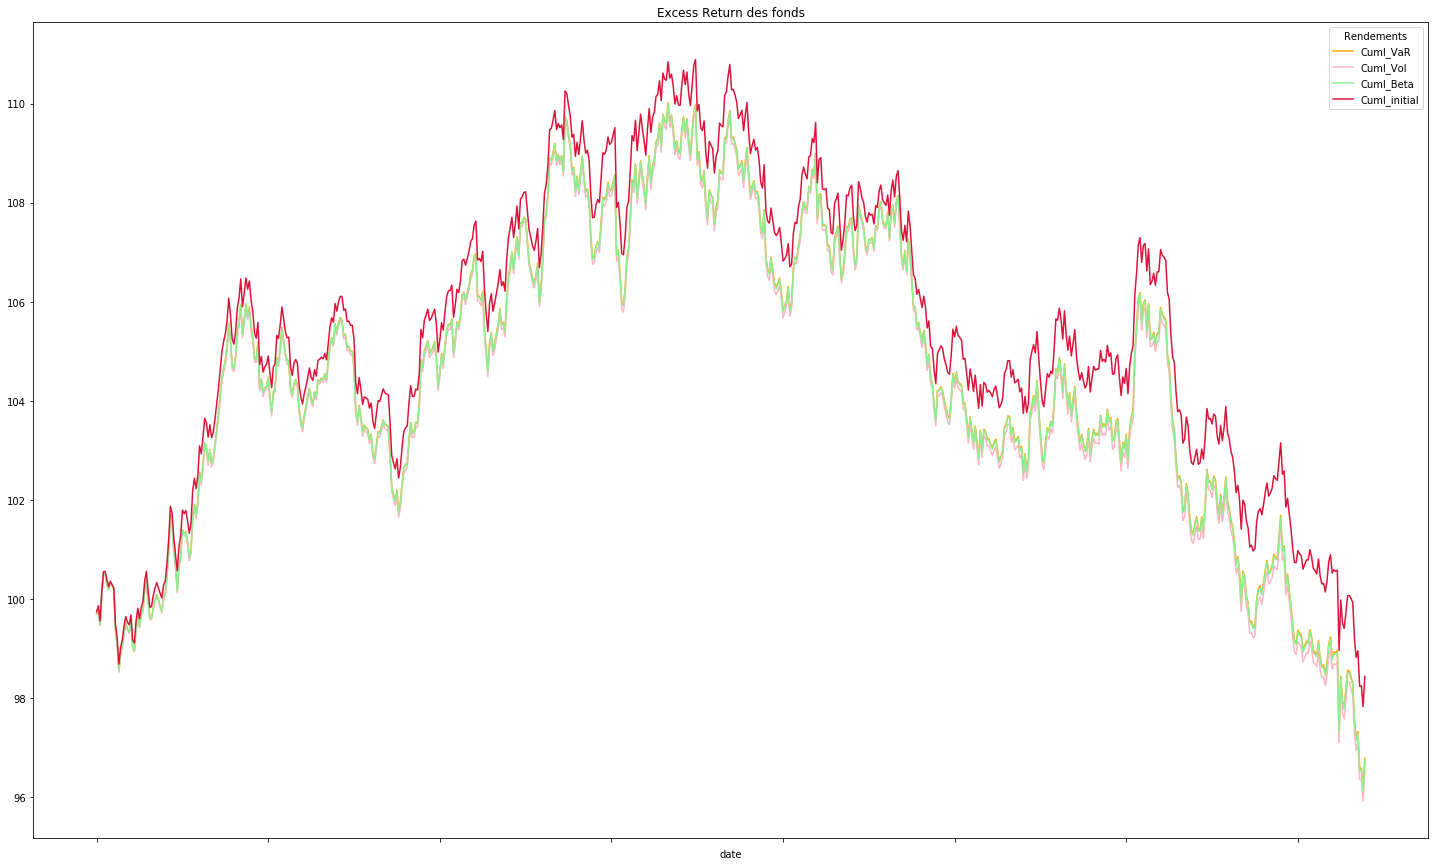

In [59]:
# récupérer slmt les rendements relatifs, ou relatifs cumulés pour plot l'excès de perf de chaque fonds
Rdt_simple_hedge_initial_bench = Rdt_hedge_initial_bench[Rdt_hedge_initial_bench.columns[pd.Series(Rdt_hedge_initial_bench.columns).str.startswith('Fonds')|pd.Series(Rdt_hedge_initial_bench.columns).str.startswith('CAC40')]]
Rdt_relatif_hedge_initial_bench = Rdt_hedge_initial_bench[Rdt_hedge_initial_bench.columns[pd.Series(Rdt_hedge_initial_bench.columns).str.startswith('Relatif_')]]
Perf_ecx_hedge_initial_bench = Rdt_hedge_initial_bench[Rdt_hedge_initial_bench.columns[pd.Series(Rdt_hedge_initial_bench.columns).str.startswith('Cuml_')]]
Perf_ecx_hedge_initial_bench.plot(title="Excess Return des fonds", figsize=(25,15),color=("orange","lightpink","lightgreen","crimson"))

Les 3 portefeuilles réduisant le risque du fonds de 5% présentent un rendement en excès inférieur au fonds initial. Cependant, on observe pas de différence majeure entre les trois nouveaux fonds en termes de surperformance. 

#### Comparaison indicateurs de risque et perf pour chaque fonds sur les 3 dernières années

Statistiques diverses,Tracking Error (annualisee),Ratio d'investissement,Performance Totale (%),Taux de recouvrement,Part d'ETF (%)
Fonds,,,,,
Fonds_VaR,0.053213,0.98,30.04,0.335321,3.96
Fonds_Vol,0.053213,0.99,29.94,0.335321,4.54
Fonds_Beta,0.053213,0.98,30.03,0.335321,4.05
Fonds_initial,0.053213,0.94,30.73,0.335321,0.00
CAC40,0.053213,NaN,24.16,NaN,0.00


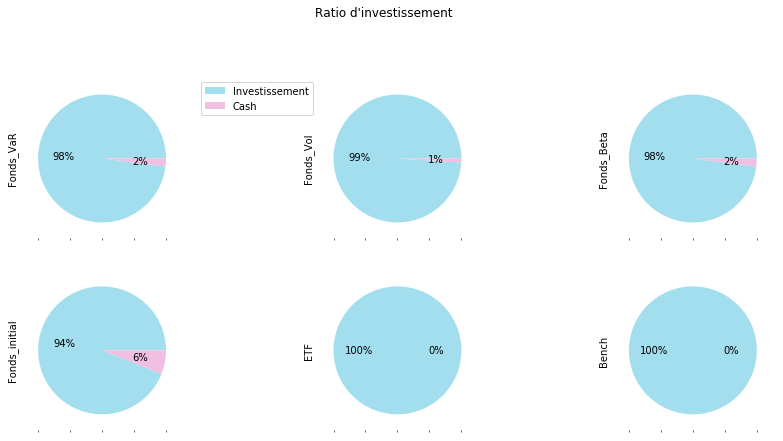

In [60]:
#Performance totale, TE, taux de recouvrement, ratio d'investissement
stat_comparaison = pd.DataFrame(columns={"Part d'ETF (%)",'Performance Totale (%)','Tracking Error (annualisee)','Taux de recouvrement',"Ratio d'investissement"})
stat_comparaison.columns.name = "Statistiques diverses"
stat_comparaison['Performance Totale (%)'] = round((Prices_hedge_initial_bench.iloc[-1,:]/Prices_hedge_initial_bench.iloc[-0,:]-1)*100,2)
stat_comparaison['Tracking Error (annualisee)'] = np.std(Rdt_relatif_hedge_initial_bench.values)*np.sqrt(252)
stat_comparaison["Part d'ETF (%)"] = np.array([round(100*w_opt_var,2) ,round(w_opt_vol* 100,2),round(w_opt_beta* 100,2), 0,0 ])
for col in Compo_hedge.columns:
    stat_comparaison.loc[col,'Taux de recouvrement']=np.sum(pd.DataFrame([Compo_hedge[col],Compo_Pf_CAC['CAC40']]).min())
stat_comparaison.loc['Fonds_initial','Taux de recouvrement']=tauxRecouvrement
stat_comparaison["Ratio d'investissement"]=RatioInv(Compo_hedge.join(Compo_Pf_CAC.reindex(sorted(Compo_Pf_CAC.columns,reverse=True), axis=1)).rename(columns={'Fonds':'Fonds_initial','CAC40':'Bench'}))['Investissement']
stat_comparaison.rename_axis("Fonds",axis=0,inplace=True)
stat_comparaison

Nous observons une performance totale supérieure pour le fonds initial. La performance totale baisse légèrement pour chaque pourcentage d'ETF ajouté. Cette baisse de la performance semble logique du fait de l'objectif de l'ETF (objectif de performance inverse à celle du CAC 40). 
Nous remarquons cependant que cette perte de performance est très faible. Parmi les 3 fonds, le premier fonds, avec une part d'ETF à 3,96% présente la performance totale la plus grande sur les 3 dernières années. 

In [61]:
#Risque annualisé, Beta, Corrélation avec le CAC40, Covariance, VaR
risk_compar = pd.DataFrame(columns={'Risque annualisé','Beta','Corrélation','Covariance','VaR Historique','Hits de VaR (5%)','CVaR Paramétrique'})
risk_compar.columns.name = "Statistiques de risque"
risk_compar['Risque annualisé'] = round(np.std(Rdt_simple_hedge_initial_bench)*np.sqrt(252),4)
for col in Compo_hedge.columns:
    risk_compar.loc[col,'Beta'] = round(Regression(Compo_hedge[col],Compo_Pf_CAC['CAC40'],Graph=False,Print=False)['beta'],4)
for col in Rdt_simple_hedge_initial_bench.columns:
    risk_compar.loc[col,'Covariance'] = (CovCor(Rdt_simple_hedge_initial_bench,col,'CAC40')[0]).round(6)
    risk_compar.loc[col,'Corrélation'] = (CovCor(Rdt_simple_hedge_initial_bench,col,'CAC40')[1]).round(2)
    risk_compar.loc[col,'VaR Historique'] = -round(VaRHistorique(Rdt_simple_hedge_initial_bench[col]),4)
    risk_compar.loc[col,'Hits de VaR (5%)'] = round(BackTestVaR(Rdt_simple_hedge_initial_bench[col],fctVaR=VaRHistorique)['pctBreach']*100,2)
    risk_compar.loc[col,'CVaR Paramétrique'] = -round(CVaRParametriqueNormale(Rdt_simple_hedge_initial_bench[col]),4)
risk_compar.loc['Fonds_initial','Beta'] = round(pf_reg_results['beta'],4)
risk_compar.loc['CAC40','Beta'] = 1
risk_compar.rename_axis("Fonds",axis=0,inplace=True)
risk_compar

Statistiques de risque,CVaR Paramétrique,Corrélation,Beta,Risque annualisé,Hits de VaR (5%),VaR Historique,Covariance
Fonds,,,,,,,
Fonds_VaR,0.2324,0.91,0.3087,0.1127,5.52,0.1834,5.4e-05
Fonds_Vol,0.231,0.91,0.3058,0.1120,5.52,0.1821,5.3e-05
Fonds_Beta,0.2322,0.91,0.3082,0.1126,5.52,0.1832,5.4e-05
Fonds_initial,0.2422,0.92,0.7973,0.1174,5.73,0.1919,5.6e-05
CAC40,0.2709,1,1,0.1313,6.13,0.2342,6.9e-05


Les 3 portefeuilles que nous avons crée avec différents objectifs de couverture à 5% ont des profils très similaires. Ils se différencient principalement du fonds initial par le profil de risque : avec une corrélation et un beta moins élevés, la value at risk et leur risque annualisé sont tous les deux plus faibles.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e73e588>,
      dtype=object)

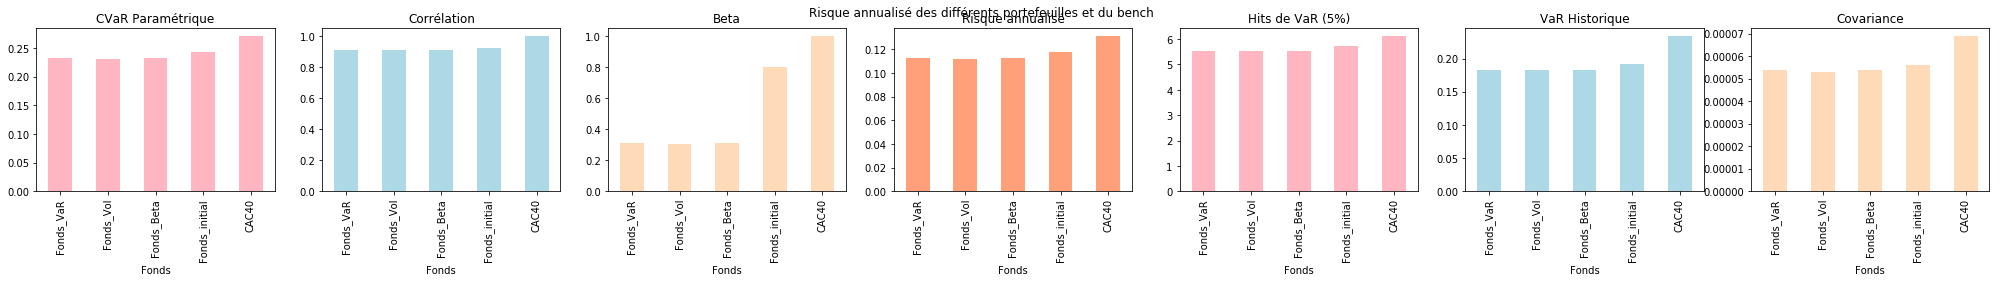

In [62]:
risk_compar.plot(kind='bar',title='Risque annualisé des différents portefeuilles et du bench',subplots=True,layout=(1,7),legend=False,figsize=(35,3),color=("lightpink","lightblue","peachpuff","lightsalmon"))


#### Conclusion : un investissement de 3,96% dans l'ETF afin de diminuer la VaR de 5%

Les 3 fonds testés obtiennent tous des profils de risque et de rendement similaire. C'est cependant le premier fonds, avec une part d'ETF à 3,96%, qui présente la performance totale la plus grande sur les 3 dernières années. Nous recommandons donc d'investir dans 3,96% de l'ETF afin de diminuer la VaR de 5% tout en préservant autant que possible la performance.  

##### Caractéristiques du portefeuille intégrant 3,96% d'ETF :

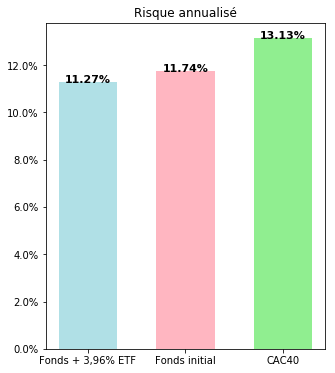

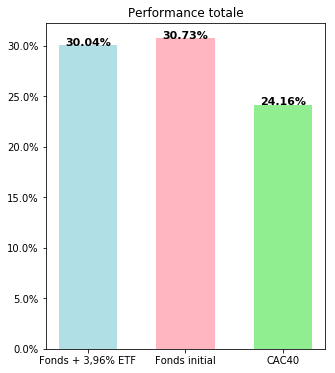

In [63]:
volVaR=Vol(Rdt_simple_hedge_initial_bench['Fonds_VaR']) 
volfonds=Vol(Rdt_simple_hedge_initial_bench['Fonds_initial']) 
volCAC=Vol(Rdt_simple_hedge_initial_bench['CAC40']) 
FondsPlot(Fonds1 = volVaR*100, labelFonds1 = "Fonds + 3,96% ETF", Fonds2 = volfonds*100, labelFonds2 = "Fonds initial", Fonds3 = volCAC*100, labelFonds3 = "CAC40",Titre="Risque annualisé")
perfTotaleVaR = PerfTot(Prices_hedge_initial_bench["Fonds_VaR"])
perfTotaleCAC = PerfTot(Prices_hedge_initial_bench["CAC40"])
perfTotaleFonds = PerfTot(Prices_hedge_initial_bench["Fonds_initial"])
FondsPlot(perfTotaleVaR*100,"Fonds + 3,96% ETF",Fonds2 = perfTotaleFonds*100,labelFonds2 = "Fonds initial",Fonds3 = perfTotaleCAC*100,labelFonds3 = "CAC40")

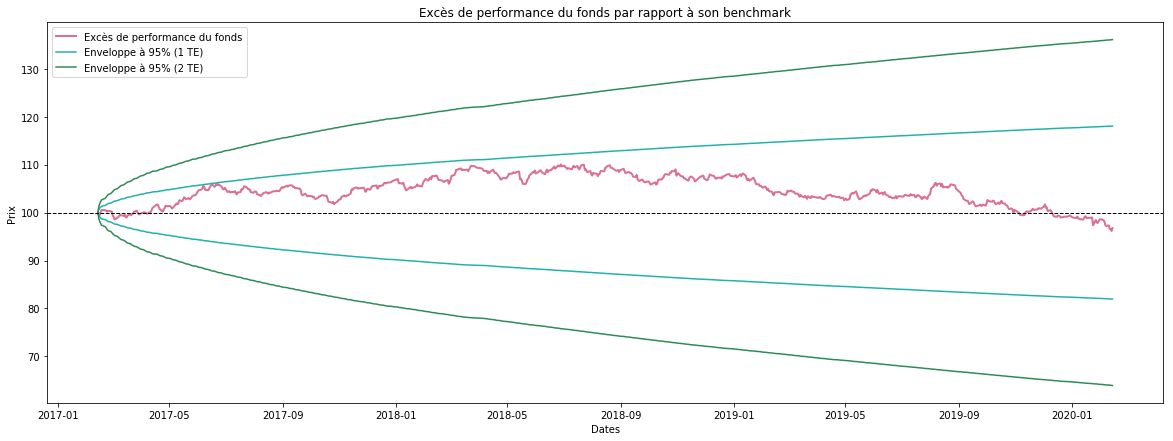

In [64]:
teVaR=TEexcPerf(Rdt_hedge_initial_bench[["Fonds_VaR","CAC40","Relatif_VaR","Cuml_VaR"]].rename(columns={"Cuml_VaR":"Cuml","Relatif_VaR":"Relatif"})) 

#### Stress test des différents fonds sur les 3 dernières années 

Nous appliquons différents stress test afin de vérifier la réaction des différents fonds : 

In [65]:
def StressTest(Choc):
    #fonction simulant un choc et calculant la VaR
    # Etape 1 : application du choc sur le CAC 40, le fonds initial, et les trois fonds hedgés
    Returns_funds = Rdt_simple_hedge_initial_bench.copy(deep=True)
    funds_choc = risk_compar["Beta"]*Choc
    Returns_funds.iloc[-1,:] = funds_choc
    # Etape 4 : calcul des VaR
    risk_compar_ST = pd.DataFrame(columns={'VaR Historique','Hits de VaR (5%)','CVaR Paramétrique','Choc'})
    risk_compar_ST.columns.name = "Statistiques de risque"
    for col in Returns_funds.columns:
        risk_compar_ST.loc[col,'VaR Historique'] = -round(VaRHistorique(Returns_funds[col]),4)
        risk_compar_ST.loc[col,'Hits de VaR (5%)'] = round(BackTestVaR(Returns_funds[col],fctVaR=VaRHistorique)['pctBreach']*100,2)
        risk_compar_ST.loc[col,'CVaR Paramétrique'] = -round(CVaRParametriqueNormale(Returns_funds[col]),4)
    risk_compar_ST['Choc'] = funds_choc
    return risk_compar_ST

#### Scénario très haussier : hausse du CAC40 de 13%

In [66]:
StressTest(0.13)

Statistiques de risque,CVaR Paramétrique,Choc,Hits de VaR (5%),VaR Historique
Fonds_VaR,0.2373,0.040131,5.52,0.1834
Fonds_Vol,0.2358,0.039754,5.52,0.1821
Fonds_Beta,0.2371,0.040066,5.52,0.1832
Fonds_initial,0.2722,0.103649,5.73,0.1919
CAC40,0.3126,0.13,6.13,0.2342


#### Scénario haussier : hausse du CAC40 de 5%

In [67]:
StressTest(0.05)

Statistiques de risque,CVaR Paramétrique,Choc,Hits de VaR (5%),VaR Historique
Fonds_VaR,0.2331,0.015435,5.52,0.1834
Fonds_Vol,0.2317,0.01529,5.52,0.1821
Fonds_Beta,0.2329,0.01541,5.52,0.1832
Fonds_initial,0.2468,0.039865,5.73,0.1919
CAC40,0.2774,0.05,6.13,0.2342


#### Scénario baissier : baisse du CAC40 de 15%

In [68]:
StressTest(-0.15)

Statistiques de risque,CVaR Paramétrique,Choc,Hits de VaR (5%),VaR Historique
Fonds_VaR,0.2391,-0.046305,5.73,0.1869
Fonds_Vol,0.2376,-0.04587,5.73,0.1853
Fonds_Beta,0.2388,-0.04623,5.73,0.1866
Fonds_initial,0.2819,-0.119595,5.93,0.1933
CAC40,0.3257,-0.15,6.34,0.2346


#### Scénario catastrophe : baisse du CAC40 de 40%

In [69]:
StressTest(-0.40)

Statistiques de risque,CVaR Paramétrique,Choc,Hits de VaR (5%),VaR Historique
Fonds_VaR,0.276,-0.12348,5.73,0.1869
Fonds_Vol,0.274,-0.12232,5.73,0.1853
Fonds_Beta,0.2757,-0.12328,5.73,0.1866
Fonds_initial,0.454,-0.31892,5.93,0.1933
CAC40,0.5525,-0.4,6.34,0.2346


De manière générale, on observe un effet d'asymétrie : les rendements négatifs apportent plus de volatilité que les rendements positifs. En effet, les chocs positifs sur le CAC40 n'entrainent pas de baisse de la VaR, tandis que les chocs sur le CAC40 se traduisent pas une hausse de la VaR et une hausse des hits de VaR. 

Dans chaque Stress Test, la VaR est bien réduite dans les fonds où l'on a investit dans de l'ETF par rapport au fonds initial. Dans les StressTest négatifs, la VaR du fonds sans investissement dans l'ETF est accrue de 1,91%. Dans le fonds avec 3,96% d'ETF ("Fonds_VaR"), la VaR n'augmente en revanche que de 0,73%, soit 4,43% en moins que sans investissement dans l'ETF (ici nous n'obtenons pas une différence de 5% car la quantité d'ETF dans laquelle investir à été déterminées pour diminuer la VaR de 5% sur l'ensemble de la période, tandis que nous n'appliquons ici les stress tests que sur les 3 dernières années).  

Les stress tests confirment donc qu'il est justifié d'investir dans le Lyxor CAC 40 Daily (-1x) Inverse pour se couvrir contre une baisse des marchés, idéalement à hauteur de 3,96%. 